# AI Enterprise Workflow - Capstone Project


# Part 1 - Data ingestion and data analysis


## Tasks

Tell the story of the data by investigating the relationship between the data and the business opportunity.

1. Business scenario and testable hypotheses.
2. State the ideal data to address the business opportunity and clarify the rationale for needing specific data.
3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.
4. Investigate the relationship between the relevant data, the target and the business metric.
5. Articulate findings using deliverables from data visualization.


## 1. Assimilate the business scenario and articulate testable hypothesis

Revenue generation is key conern for AAVAIL management team. For many years AAVAIL revenue was generated with a tiered, subscription-based service. But now, to remain attractive for their customers, AAVAIL has to introduce à la carte approach. An inhibitor for the switch to the new revenue model is difficulty to predict monthly revenue. 

The objective of this project is to create a service that, at any point in time, will predict the revenue for the following month, with ability to project revenue for a specific country, starting with ten countries with the most revenue.

The management team expects to spend less time creating projection models, and they expect the new results to be more accurate comparing to their own models. 

**Testable Hypothesis**

The new model could be more accurate than the current spreadsheets because AI can handle more data and solve complex solutions. Additionally, the full automatization will make the process robust and less prone to errors due to reduced human operations. 


## 2. State the ideal data to address the business opportunity and clarify the rationale for needing specific data

We are targeting monthly revenue per country. 

In order to train and test the model historical revenues data is needed, where revenue is provided as the product of price and volume.

Historical data from invoices could be used to predict the revenues. Data such as country, customer, product, price and volume could be used to calculate the revenues and identify the most significant factors having impact on revenue prediction.

## 3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion

**Data ingestion script**

In [1]:
%%writefile data_ingestion.py
#!/usr/bin/env python

import os
import re
import time
import numpy as np
import pandas as pd
from datetime import datetime

## Project directories
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join("data")
DEV = True
   
def _ingest_data(dev=DEV, verbose=True):
    """
    load, join and clean json invoice data
    """
    
    if dev:
        data_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"train-source")
    else:
        data_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"production-source")
    
    ## Check the data directory
    if not os.path.exists(data_dir):
        raise Exception("specified data dir does not exist")
    
    if not len(os.listdir(data_dir))>=1:
        raise Exception("specified data dir does not contain any files")
        
    ## create a list with all json files in the data directory
    if verbose:
        print("...reading from json files")
    json_files = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    
    ## read json file from the data directory
    total = len(json_files)
    if verbose:
        print("...{} json files in the '{}' directory".format(total, data_dir))
    aavail_data = {}
    for iteration,json_file in enumerate(json_files):
        if verbose:
            end = "" if (iteration+1) < total else "\n"
            print("\r...reading file: {}/{}".format(iteration+1,total), end=end)
        key = os.path.split(json_file)[-1]
        df = pd.read_json(json_file)
        aavail_data[key] = df
    
    ## set default columns names
    column_names = ['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']
    
    ## rename columns to uniformly named features
    for invoice, df in aavail_data.items():
        if "StreamID" in df.columns.values:
            df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if "TimesViewed" in df.columns.values:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in df.columns.values:
            df.rename(columns={'total_price':'price'},inplace=True)
        if set(df.columns.values) != set(column_names):
            raise Exception("column names for {} could not be matched to correct columns".format(invoice))
    
    ## concatenate the data to one dataframe
    df = pd.concat(aavail_data, ignore_index=True)
    print("...concatenated to dataset of {} rows and {} columns".format(df.shape[0], df.shape[1]))
    
    ## extract date from year, month and day
    df["invoice_date"] = pd.to_datetime(df[["year","month","day"]])

    ## remove any letters from invoice IDs
    df["invoice_id"] = df["invoice"].str.replace(pat="\D+", repl="", regex=True).values.astype(np.int)
    df.drop(["invoice"], axis=1, inplace=True)
    
    return df

def _convert_to_ts(df, country=None):
    """
    convert the original clean dataframe to a time series
    by aggregating over each day for the given country
    """
    
    ## define the columns to group
    if country:
        cols = ["invoice_date", "country"]
    else:
        cols = ["invoice_date"]
        
    ## group the data    
    grouped = df.groupby(cols)
    
    ## count the purchases
    df_count = grouped[["price"]].count()
    df_count.rename(columns={'price':'purchases'},inplace=True)
    
    ## apply aggregation functions
    df_aggr = grouped.agg({"invoice_id":"nunique","stream_id": "nunique","times_viewed":"sum","price":"sum"})
    df_aggr.rename(columns={"invoice_id":"unique_invoices","stream_id":"unique_streams","times_viewed":"total_views","price":"revenue"}, inplace=True)
    
    ## merge the counts and the results from aggregation
    df_final = df_count.merge(df_aggr, left_index=True, right_index=True).reset_index()
    
    if country:
        mask = df_final.country == country
        return df_final[mask].drop("country", axis=1).set_index("invoice_date")
    else:
        return df_final.set_index("invoice_date")
    
def ingest_ts(clean=True, dev=DEV, verbose=True):
    """
    fetch timeseries data
    if the csv files exist, it reads from the file directory,
    otherwise it creates them from the source and saves the files
    """
    
    if verbose:
        print("Ingesting Data")
    
    if dev:
        ts_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"train-timeseries")
    else:
        ts_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"production-timeseries")
        
    ## check the data directory
    if not os.path.exists(ts_dir):
        os.makedirs(ts_dir)
        
    if (len(os.listdir(ts_dir)) > 0) & (clean == False):
        if verbose:
            print("...loading timeseries data from files")
        ts_files = [os.path.join(ts_dir,f) for f in os.listdir(ts_dir) if re.search("\.csv",f)]
        return {re.sub("\.csv","",os.path.split(f)[-1]):pd.read_csv(f, index_col=0) for f in ts_files}
        
    ## load source data
    df = _ingest_data(dev=dev, verbose=verbose)
    
    ## top10 countries by revenue
    top_10_countries = df.groupby("country")[["price"]].sum().sort_values(by="price",ascending=False)[:10].index.values.tolist()
    
    ## add total to the countries
    countries = top_10_countries
    countries.append("Total")
    
    ## convert the data to timeseries
    ts = {}
    if verbose:
        print("Converting data to timeseries")
    for country in countries:
        key = re.sub("\s+","_",country.lower())
        if key == "total":
            ts[key] = _convert_to_ts(df)
        else:
            ts[key] = _convert_to_ts(df, country=country)
        
        ## write file
        csv_path = os.path.join(ts_dir,"{}.csv".format(key))
        ts[key].to_csv(csv_path, index=True)
        
    return ts

def load_feature_matrix(clean=False, dev=DEV, verbose=True):
    """
    load the clean dataset after ingestion
    """
    
    ## load the dataset
    ts = ingest_ts(clean=clean, dev=dev, verbose=verbose)
    
    if verbose:
        print("Creating Feature Matrix")
    
    df = pd.concat(ts, keys=ts.keys(), names=["country"]).reset_index()

    ## set invoice_date data type
    if df.dtypes["invoice_date"] != "datetime64[ns]":
        df["invoice_date"] = pd.to_datetime(df["invoice_date"])
        
    return df

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## ingest data
    ts = ingest_ts(dev=DEV)
    
    ## metadata
    for key, item in ts.items():
        print("...{} {}".format(key, item.shape))
    
    ## running statistics
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("Completed in:", "%d:%02d:%02d"%(h, m, s))
    

Overwriting data_ingestion.py


**Run data ingestion script**

In [2]:
%run data_ingestion.py

Ingesting Data
...reading from json files
...21 json files in the './data/train-source' directory
...reading file: 21/21
...concatenated to dataset of 815011 rows and 9 columns
Converting data to timeseries
...united_kingdom (495, 5)
...eire (293, 5)
...germany (359, 5)
...france (285, 5)
...norway (19, 5)
...spain (104, 5)
...hong_kong (9, 5)
...portugal (72, 5)
...singapore (6, 5)
...netherlands (133, 5)
...total (495, 5)
Completed in: 0:00:21


## 4. Investigate the relationship between the relevant data, the target and the business metric

**Data visualization script**

In [4]:
%%writefile data_visualization.py
#!/usr/bin/env python

import re
import time
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

## import functions to load the data
from data_ingestion import load_feature_matrix
from data_ingestion import DEV

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


IMAGE_DIR = os.path.join(".","images")

def save_fig(fig_id, tight_layout=True, image_path=IMAGE_DIR):
    """
    save the image as png file in the image directory
    """
    
    ## create the image directory
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    
    path = os.path.join(image_path, fig_id + ".png")
    print("...saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def create_plots(df):
    """
    create plots for data visualizations
    """
    print("Creating plots")
    
    ## analyze total revenues over time
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    table = df[df.country=="total"].set_index("invoice_date")[["revenue"]].resample("MS").sum()
    table.plot(ax=ax1)
    ax1.set_xlabel("months")
    ax1.set_ylabel("revenues")
    ax1.title.set_text("Total monthly revenue")
    save_fig("monthly_revenues")
    
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    df["year"] = df.invoice_date.dt.year
    table = df[df.country=="total"].set_index("invoice_date")[["revenue"]].resample("AS").sum()
    table.plot(kind='bar', stacked=False, ax=ax1, rot=0)
    ax1.set_xlabel("year")
    ax1.set_ylabel("revenue")
    ax1.title.set_text("Total revenue per year")
    save_fig("yearly_revenues")
    
    ## analyze revenues per country
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    table = pd.pivot_table(df[df.country!="total"], index = ['country'], columns=["year"],values = 'revenue', aggfunc="sum")
    table.plot(kind='bar', stacked=False, ax=ax1, rot=90)
    ax1.set_xlabel("country")
    ax1.set_ylabel("revenues")
    ax1.title.set_text("Revenue in the top 10 countries")
    save_fig("revenues_per_country")
    
    ## analyze revenues in UK vs Total revenues
    mask = (df.country=="united_kingdom") | (df.country=="total")
    df_filter = df[mask].copy()
    df_filter.drop(["invoice_date", "year"], axis=1, inplace=True)
    
    # revenue correlation matrix
    fig = plt.figure(figsize=(8,8))
    num_features = ["purchases","unique_invoices","unique_streams","total_views","revenue"]
    corrmat = df_filter.corr()
    k = len(num_features) #number of variables for heatmap
    cols = corrmat.nlargest(k, 'revenue')['revenue'].index
    cm = np.corrcoef(df_filter[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    save_fig("correlations")

if __name__ == "__main__":
    
    run_start = time.time()
    
    df = load_feature_matrix(dev=DEV, clean=False)
    create_plots(df)
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("Completed in:", "%d:%02d:%02d"%(h, m, s))
    

Overwriting data_visualization.py


**Run data visualizations script**

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Creating plots
...saving figure monthly_revenues
...saving figure yearly_revenues
...saving figure revenues_per_country
...saving figure correlations
Completed in: 0:00:03


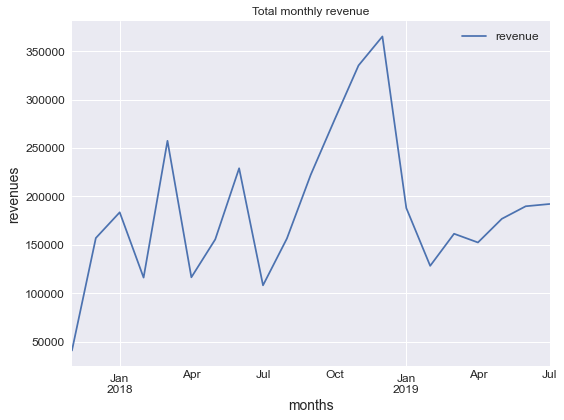

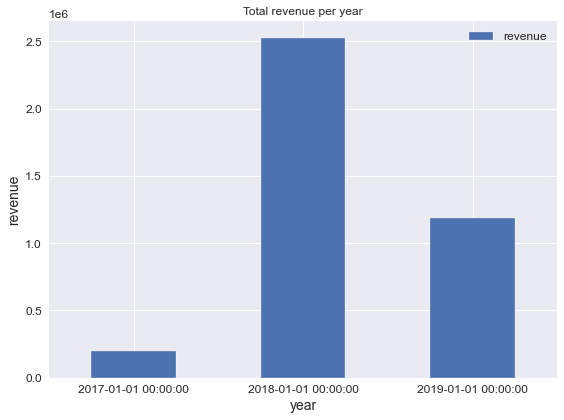

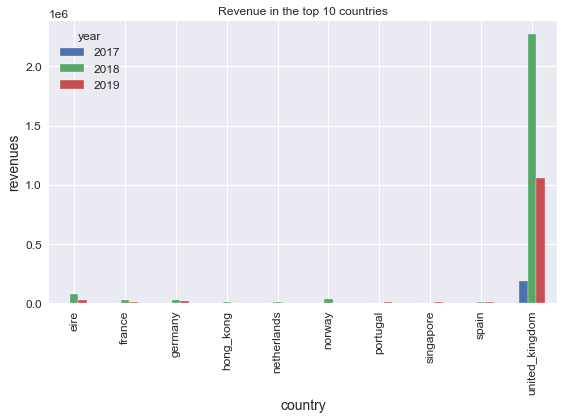

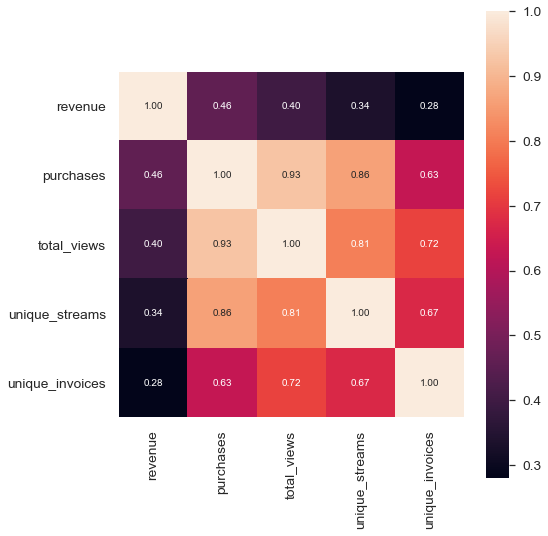

In [5]:
%run data_visualization.py

## 5. Articulate findings with deliverables from data visualization

**Analyze total revenues**

Analyzing total revenues over time will help to understand how total revenues developed over the last years. 

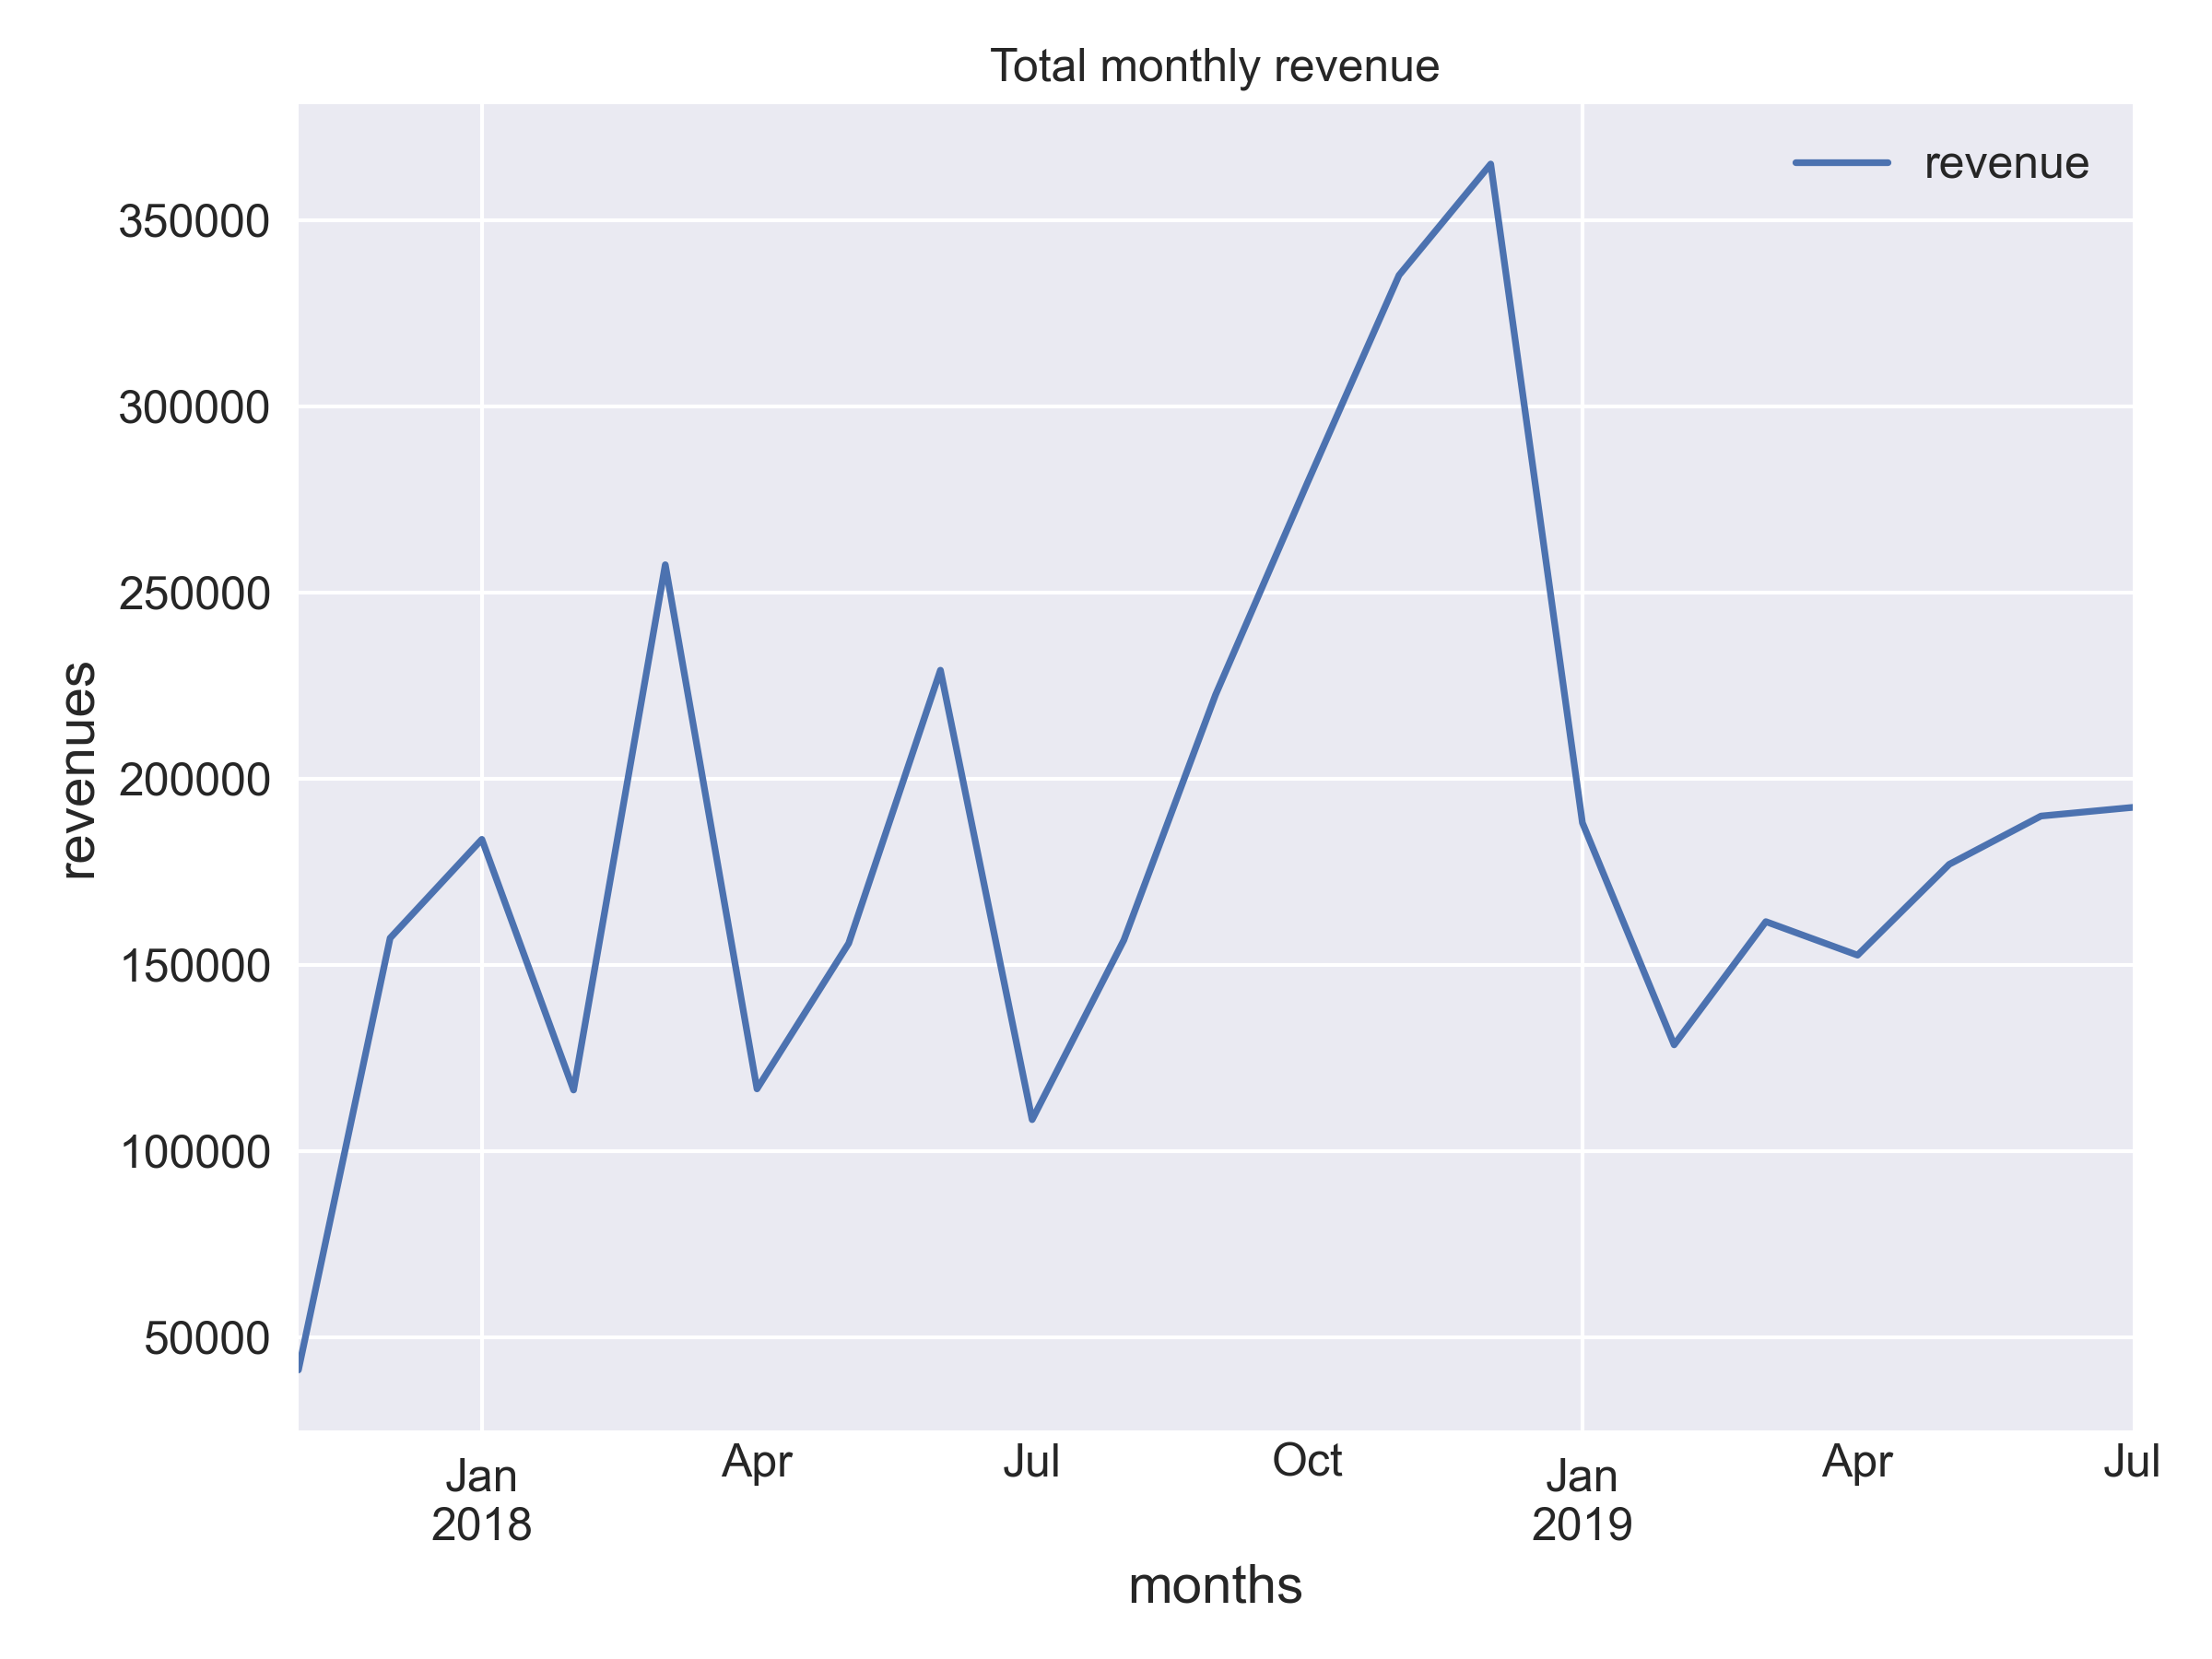

In [6]:
Image("./images/monthly_revenues.png",width=500,height=500)

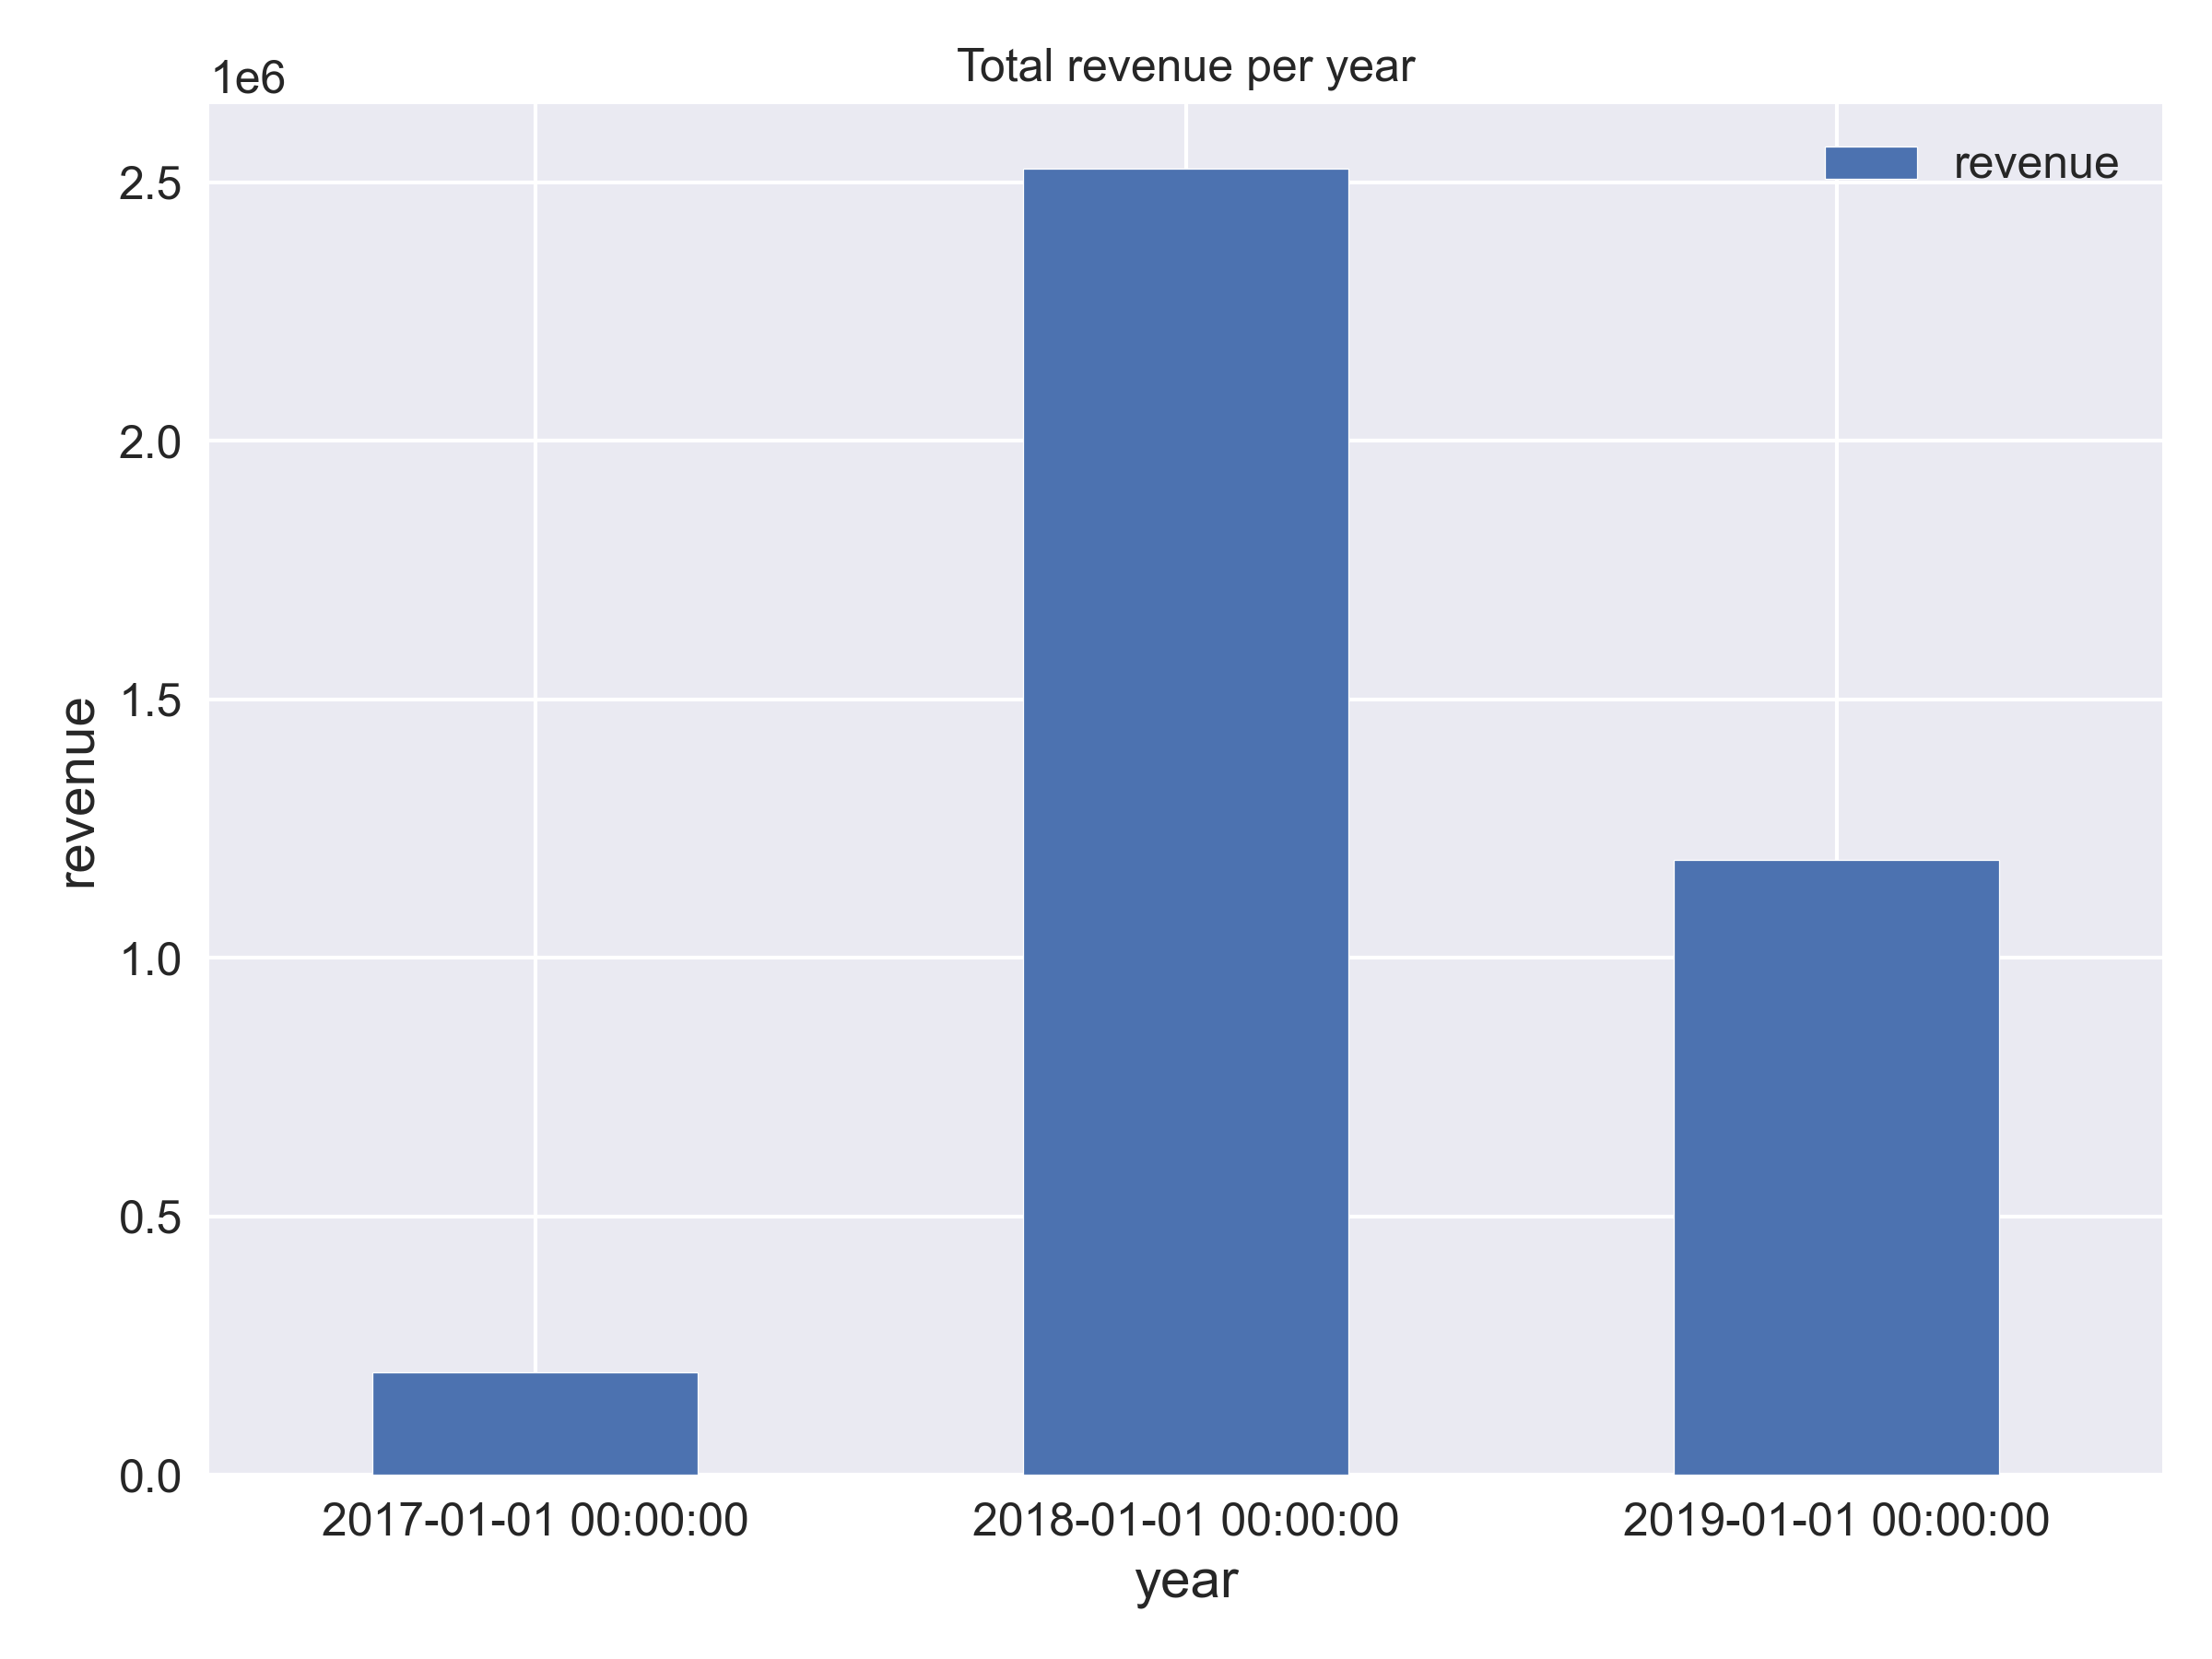

In [7]:
Image("./images/yearly_revenues.png",width=500, height=500)

 **Conclusions**
 1. The total revenues does not follows a seasonality pattern
 2. 2018 is the year with the highest revenues of 2.5 Millions
 3. 2019 is not complete due to limited data availability

**Analyze revenues per country**

Let's analyze the revenues developed for the top countries.

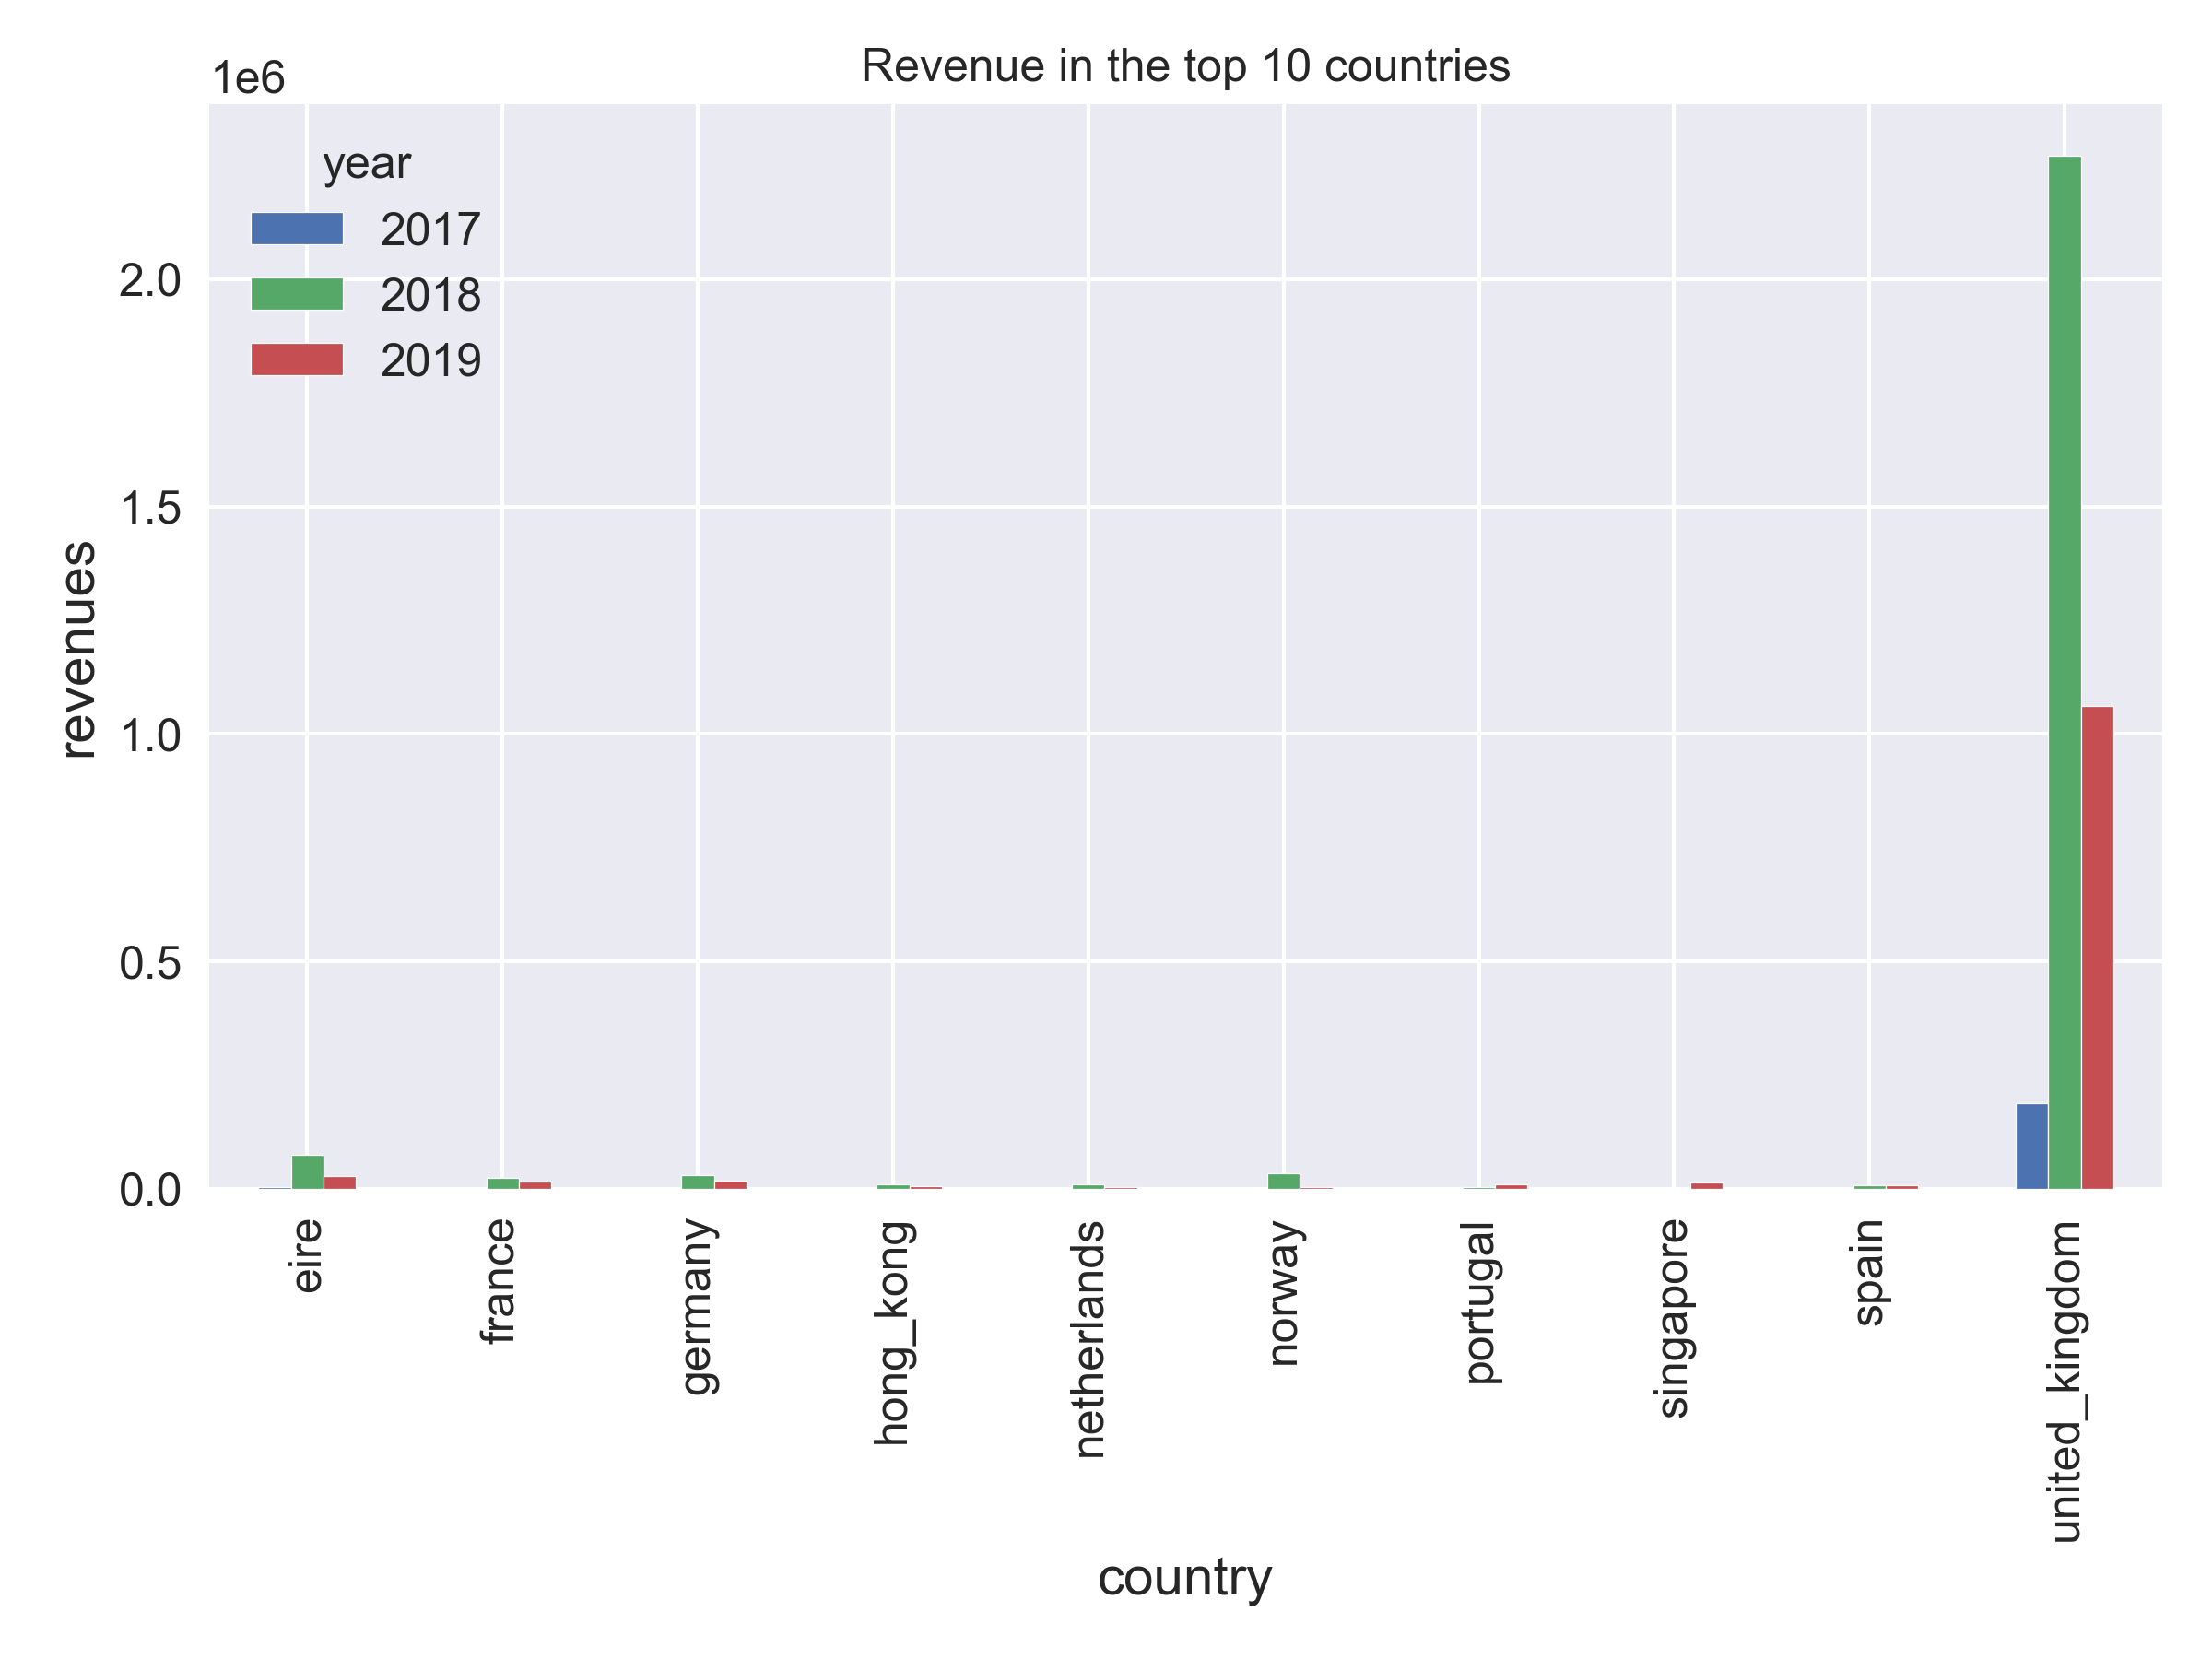

In [8]:
Image("./images/revenues_per_country.png",width=500, height=500)

**Conclusions**

1. UK is the main revenue generating market over time
2. EIRE followed
3. The other markets show significantly lower revenues

**Analyze Revenues in UK compared to the Total**

We have identified that UK is the dominant market. We will compare it with the total revenues.

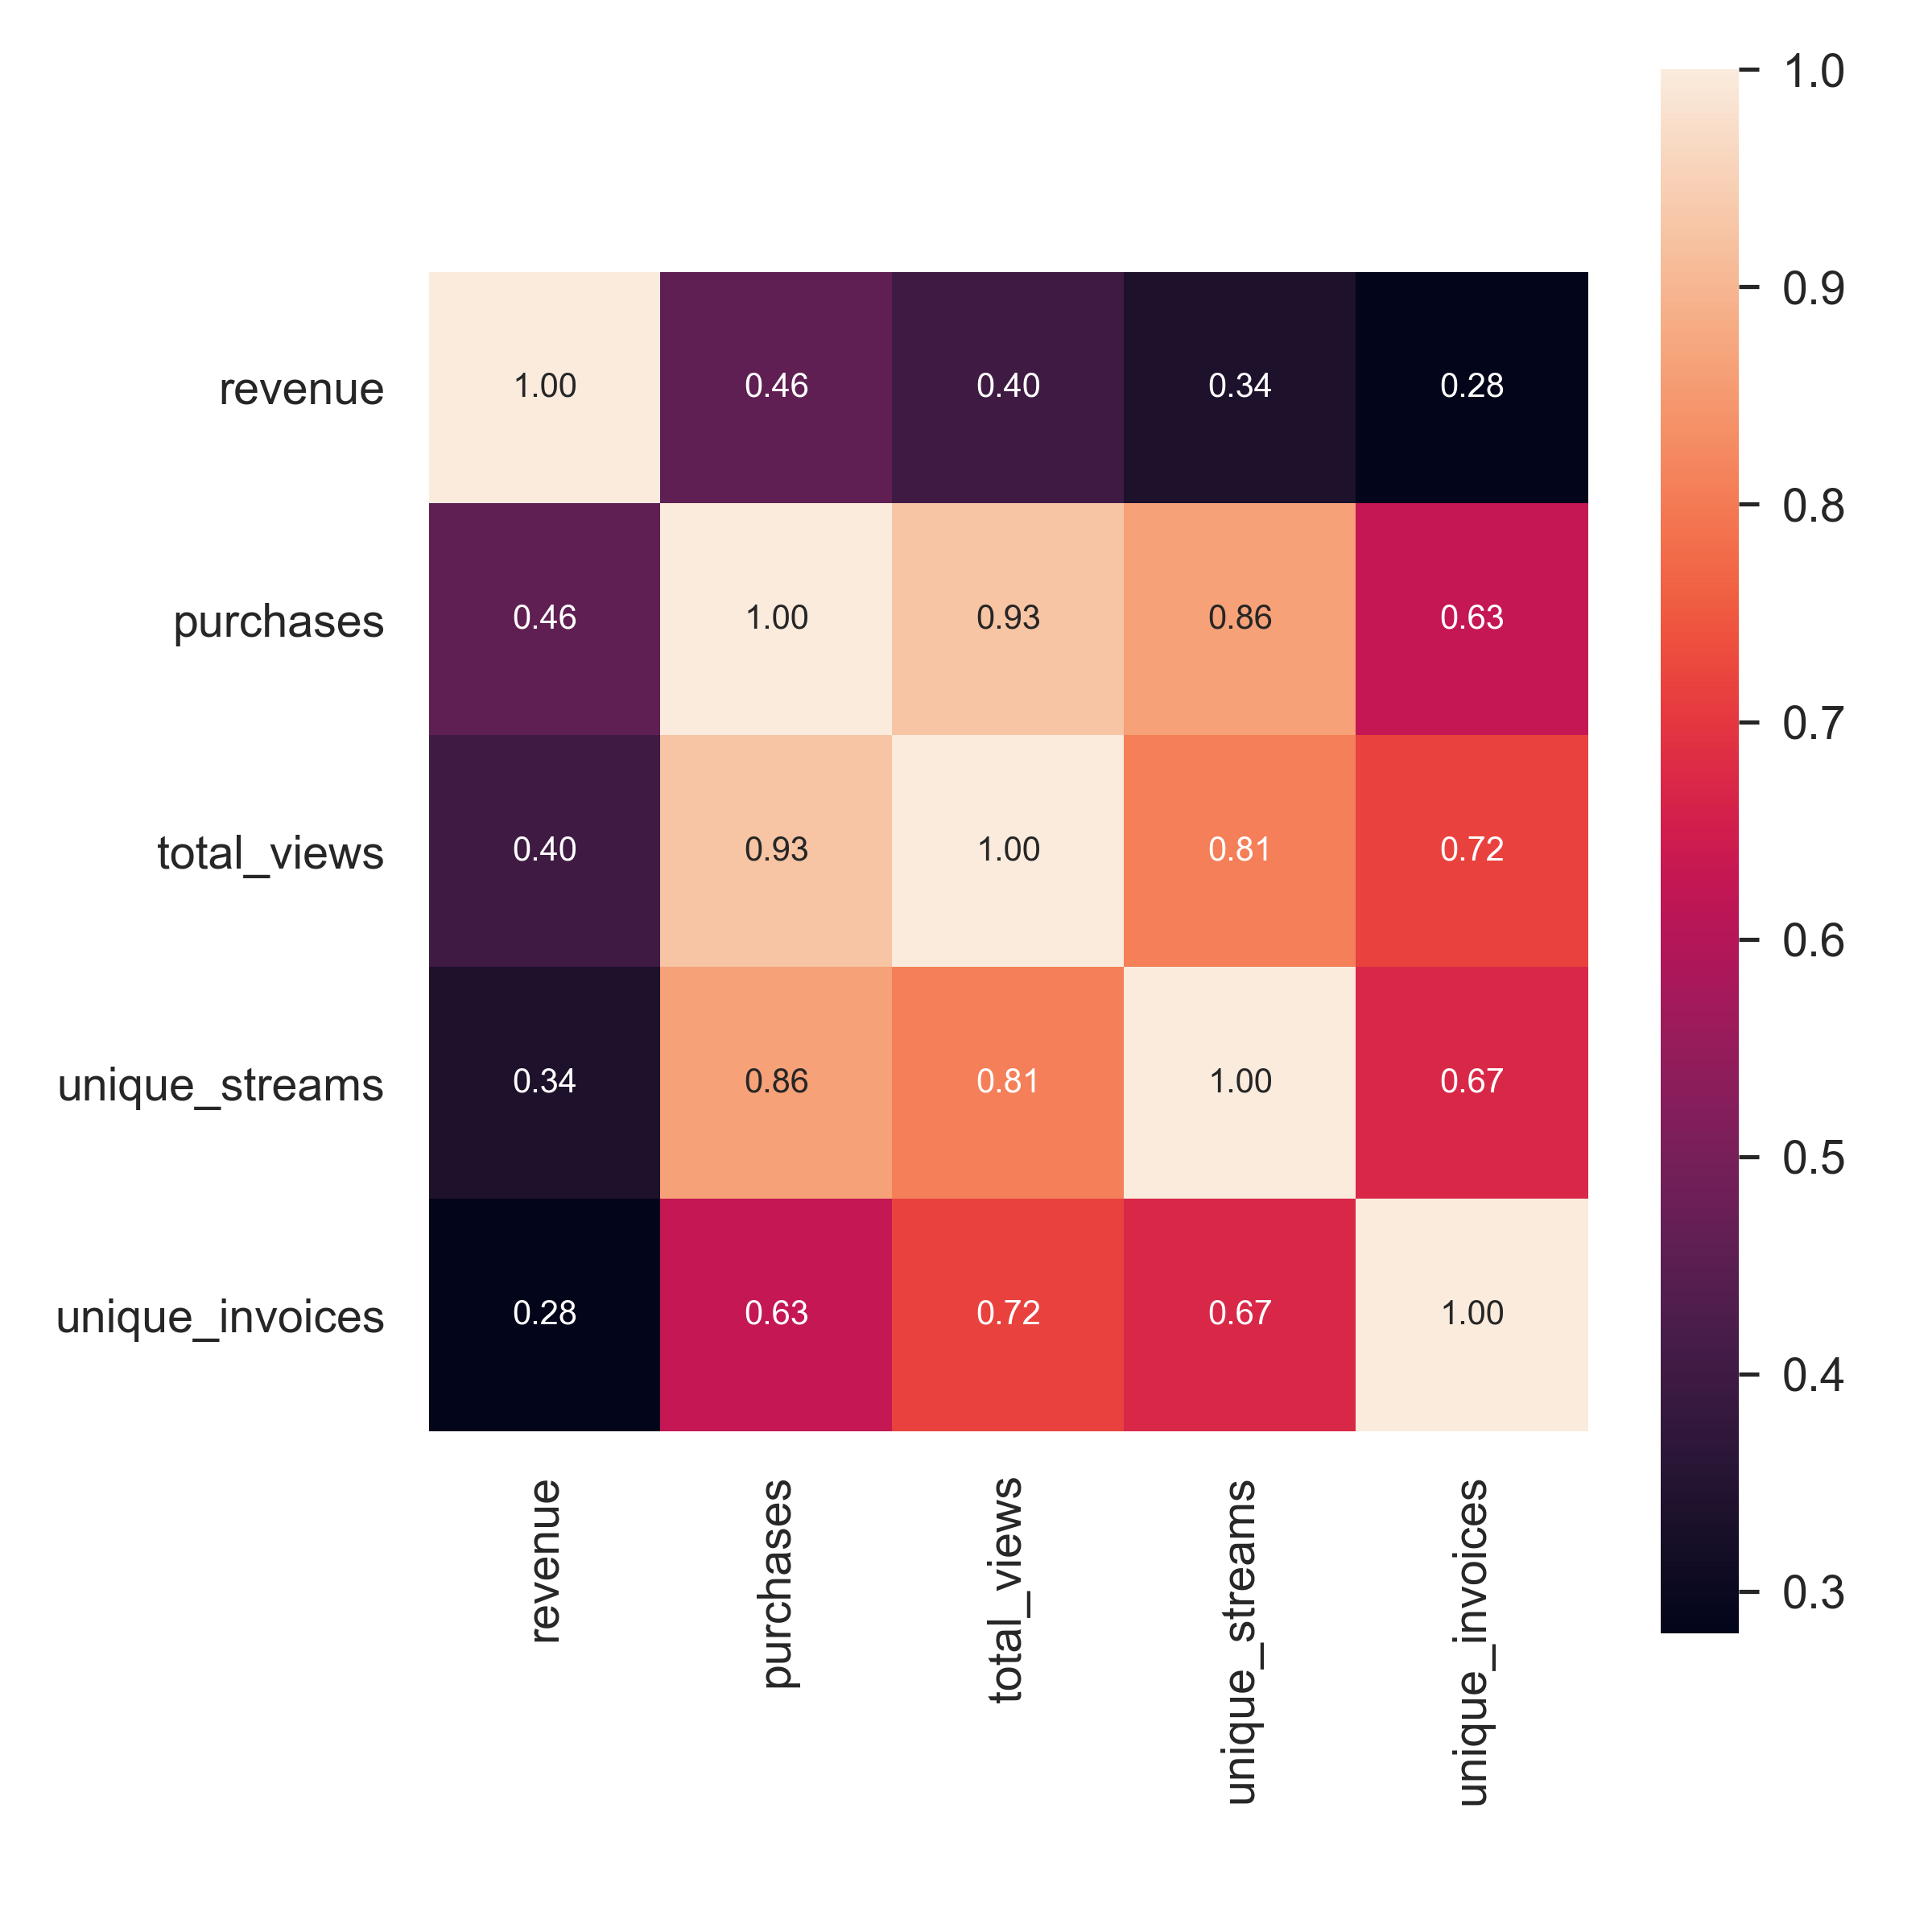

In [9]:
Image("./images/correlations.png",width=500, height=500)

**Conclusions**

1. Revenues are positively correlated with the purchases

# Part 2 - Model building and model selection

The goal of this project is time-series forecasting, which can be thought of as the use of a model to predict future values based on previously observed values. So we could try to predict purchases, number of views or the feature most closely related to our business opportunity, revenue.


## Tasks

1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.


## 1. State the different modeling approaches that you will compare to address the business opportunity.

Data engineering approach followed:

1. Engineer features with rolling window.
When forecasting the revenues only the realized values are known. For each instance in the dataset we have to come up with additional features that refer to historical values.

2. Target value rolling window.
To standardize the approach across models we have to ensure that the target is (1) the sum of revenues over the next 30 days for any given point in time and (2) is represented as a single number.

**Data engineering script**

In [10]:
%%writefile data_engineering.py
#!/usr/bin/env python

import os
import re
import time
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## import function to load feature matrix
from data_ingestion import load_feature_matrix
from data_ingestion import DEV

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    apply rolling window to engineer features
    """
    def __init__(self, shift=1, attributes=['revenue'], func="sum"):
        self.shift = shift
        self.attributes = attributes
        self.freq = "{}D".format(self.shift)
        self.func = func
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        ## set time as index
        X_ts = X.set_index(["invoice_date"])
        
        ## rolling window
        if self.func == "sum":
            X_eng = X_ts[self.attributes].rolling(self.freq, closed="left").sum()
        else:
            X_eng = X_ts[self.attributes].rolling(self.freq, closed="left").mean()
        
        ## merge with initial dataset and fill NAs
        X_eng = X_ts.merge(X_eng, left_index=True, right_index=True, how="left", suffixes=["","_m{}".format(self.freq)]).fillna(0)
        return X_eng.reset_index()

class TargetEngineer(BaseEstimator, TransformerMixin):
    """
    apply day rolling window and shift backwards
    to engineer the predicted summed revenue
    """
    def __init__(self, shift=30, attributes=['revenue']):
        self.shift = shift
        self.attributes = attributes
        self.freq = "{}D".format(self.shift)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        ## set time as index
        X_ts = X.set_index(["invoice_date"])
        
        ## rolling window
        X_eng = X_ts[self.attributes].rolling(self.freq, closed="left").sum().shift(-self.shift,"D")
        
        ## merge with the original
        X_eng = X_ts.merge(X_eng, left_index=True, right_index=True, how="left", suffixes=["","_p{}".format(self.freq)])
        
        return X_eng.reset_index()

def engineer_features(training=False, clean=False, dev=DEV, verbose=True):
    """
    engineer feature matrix and target value
    """
    
    ## load feature matrix
    fm = load_feature_matrix(dev=dev, clean=clean, verbose=verbose)
    
    if verbose:
        print("Engineering Features and Target")
    
    ## ensure that all days are accounted for each country
    fm = fm.set_index(["invoice_date","country"]).unstack(1).asfreq("1D")
   
    ## fill NAs with zero (assume no revenue was generated that day)
    fm = fm.fillna(0).stack(1).reset_index()
    
    ## unique countries
    countries = fm.country.unique()
    
    ## original features
    features = ["invoice_date","purchases","unique_invoices","unique_streams","total_views","revenue"]
    
    ## non-revenue feautures
    nonrevenue_features = ["purchases","unique_invoices","unique_streams","total_views"]
    
    eng_features = {}
    for country in countries:
        
        ## filter on country
        df = fm.query("country==@country").drop("country", axis=1)
        
        ## build pipeline to transform features
        pipe_engineer = Pipeline([
            ("revenue7D", FeatureEngineer(shift=7)),
            ("revenue14D", FeatureEngineer(shift=14)),
            ("revenue28D", FeatureEngineer(shift=28)),
            ("revenue35D", FeatureEngineer(shift=35)),
            ("revenue54D", FeatureEngineer(shift=54)),
            ("nonrevenue30D", FeatureEngineer(attributes=nonrevenue_features, shift=30, func="mean"))
        ])
        
        ## engineer features
        X = pipe_engineer.transform(df)
        
        ## keep the dates
        dates = X[["invoice_date"]].copy()
        
        ## features sanity ckeck
        test_date = dates.invoice_date.dt.strftime('%Y-%m-%d')[10]
        v1 = df.query("invoice_date<@test_date")[["revenue"]].tail(14).sum().values
        v2 = X.query("invoice_date==@test_date")["revenue_m14D"].values.ravel()
        if not np.array_equal(v1.round(2), v2.round(2)):
            print("Error! Engineer features didn't work as expected")
            
        ## drop original features
        X.drop(features, axis=1, inplace=True)
        
        ## keep the names of the engineered features
        features_labels = X.columns.values
        
        ## build instance to transform target
        target_eng = TargetEngineer()
        
        ## engineer target
        y = target_eng.transform(df)
        
        ## target sanity check
        v1 = df.query("invoice_date>=@test_date")[["revenue"]].head(30).sum().values
        v2 = y.query("invoice_date>=@test_date").head(1)["revenue_p30D"].values.ravel()
        if not np.array_equal(v1.round(2), v2.round(2)):
            print("Opps! Engineer target didn't work as expected")
        
        ## drop original features
        y.drop(features, axis=1, inplace=True)
            
        if training:
            ## remove dates with NAs
            ## the 30-day rolling and shift back for the target results in NAs for the last 30 days
            mask = y["revenue_p30D"].notna()
            X = X[mask]
            y = y[mask]
            dates = dates[mask]
            X.reset_index(drop=True, inplace=True)
            y.reset_index(drop=True, inplace=True)
            dates.reset_index(drop=True, inplace=True)
        
        ## store them as numpy arrays
        eng_features[country]= (X.values, y.values.ravel(), dates.values.ravel(), features_labels)
    
    return eng_features

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## engineer data
    datasets = engineer_features(training=True, dev=DEV)
    
    for key, item in datasets.items():
        print("...{} X:{}, y:{}".format(key.upper(), item[0].shape, item[1].shape))
    
    ## run time
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("Completed in:", "%d:%02d:%02d"%(h, m, s))
    

Overwriting data_engineering.py


**Run data engineering script**

In [11]:
%run data_engineering.py

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Engineering Features and Target
...EIRE X:(581, 9), y:(581,)
...FRANCE X:(581, 9), y:(581,)
...GERMANY X:(581, 9), y:(581,)
...HONG_KONG X:(581, 9), y:(581,)
...NETHERLANDS X:(581, 9), y:(581,)
...NORWAY X:(581, 9), y:(581,)
...PORTUGAL X:(581, 9), y:(581,)
...SINGAPORE X:(581, 9), y:(581,)
...SPAIN X:(581, 9), y:(581,)
...TOTAL X:(581, 9), y:(581,)
...UNITED_KINGDOM X:(581, 9), y:(581,)
Completed in: 0:00:00


## 2 & 3. Model selection

For each country a model is built and trained. Since the features have different scales, we need to scale the data. 

The algorithms explored are:
1. Stochastic Gradient Descent
2. Random Forest Regressor
3. Gradient Bossting Regressor
4. Ada Boosting Regressor

For each algorithm we used scikit-learn Pipeline and GridSearchCV to fine tune the hyperparameters and find the optimal model.


**Log model run results script**

In [12]:
%%writefile log.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import pandas as pd
from datetime import date

PROJECT_DIR = "."
LOG_DIR = os.path.join("logs")

## import mode
from data_ingestion import DEV

def _update_train_log(tag,algorithm,score,runtime,model_version,model_note,dev=DEV, verbose=True):
    """
    update train log file
    """
    if verbose:
        print("...updating train log")
    
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
        
    ## name the logfile using something that cycles with date (day, month, year)    
    today = date.today()
    if dev:
        logfile = "{}-train-{}-{}.log".format("test",today.year, today.month)
    else:
        logfile = "{}-train-{}-{}.log".format("prod",today.year, today.month)
    
    ## write the data to a csv file
    logpath = os.path.join(LOG_DIR, logfile)
    
    ## write the data to a csv file    
    header = ["unique_id","timestamp",'tag','score',"runtime",'model_version','model_note']
    write_header = False
    if not os.path.exists(logpath):
        write_header = True
    with open(logpath,'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|')
        if write_header:
            writer.writerow(header)
        to_write = map(str,[uuid.uuid4(),time.time(),tag,algorithm,score,runtime,model_version,model_note])
        writer.writerow(to_write)
        
def _update_predict_log(tag,y_pred,target_date,runtime,model_version,model_note,dev=DEV, verbose=True):
    """
    update predict log file
    """
    
    if verbose:
        print("...update predict log")
    
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
        
    ## name the logfile using something that cycles with date (day, month, year)    
    today = date.today()
    if dev:
        logfile = "{}-predict-{}-{}.log".format("test",today.year, today.month)
    else:
        logfile = "{}-predict-{}-{}.log".format("prod",today.year, today.month)
    
    ## write the data to a csv file
    logpath = os.path.join(LOG_DIR, logfile)
    
    ## write the data to a csv file    
    header = ["unique_id","timestamp",'tag','y_pred',"target_date","runtime",'model_version','model_note']
    write_header = False
    if not os.path.exists(logpath):
        write_header = True
    with open(logpath,'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|')
        if write_header:
            writer.writerow(header)
        to_write = map(str,[uuid.uuid4(),time.time(),tag,y_pred,target_date,runtime,model_version,model_note])
        writer.writerow(to_write)
        
def log_load(tag,year,month,env,verbose=True):
    """
    load requested log file
    """
    logfile = "{}-{}-{}-{}.log".format(env,tag,year,month)
    
    if verbose:
        print(logfile)
    return logfile
    

Overwriting log.py


**Model engineering**

In [13]:
%%writefile model.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

PROJECT_ROOT_DIR = "."
MODEL_DIR = os.path.join("models")
MODEL_VERSION = 0.1
MODEL_VERSION_NOTE = "supervised learing model for time-series"

## load from project package
from data_ingestion import DEV
from data_engineering import engineer_features
from data_visualization import save_fig
from log import _update_train_log, _update_predict_log

def _plot_learning_curve(estimator, X, y, ax=None, cv=5):
    """
    an sklearn estimator 
    """

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    train_sizes=np.linspace(.1, 1.0, 6)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=-1,
                                                            train_sizes=train_sizes,scoring="neg_mean_squared_error")
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ## axes and lables
    buff = 0.05
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xbuff = buff * (xmax - xmin)
    ybuff = buff * (ymax - ymin)
    ax.set_xlim(xmin-xbuff,xmax+xbuff)
    ax.set_ylim(ymin-ybuff,ymax+ybuff)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("MSE Score")
    
    ax.legend(loc="best")

def _make_compare_plot(X, y, models, verbose=True):
    """
    create learning curves for SGD, RF, GB and ADA
    """
    fig = plt.figure(figsize=(8, 8), facecolor="white")
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    if verbose:
        print("...creating learning curves")
    
    ## sgd
    reg1 = SGDRegressor(**models["SGD"][1])
    pipe1 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg1)])
    _plot_learning_curve(pipe1, X, y, ax=ax1)
    ax1.set_title("Stochastic Gradient Regressor")
    ax1.set_xlabel("")
    
    ## random forest
    reg2 = RandomForestRegressor(**models["RF"][1])
    pipe2 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg2)])
    _plot_learning_curve(pipe2, X, y, ax=ax2)
    ax2.set_title("Random Forest Regressor")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    
    ## gradient boosting
    reg3 = GradientBoostingRegressor(**models["GB"][1])
    pipe3 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg3)])
    _plot_learning_curve(pipe3, X, y, ax=ax3)
    ax3.set_title("Gradient Boosting Regressor")
    
    ## ada boosting
    reg4 = AdaBoostRegressor(**models["ADA"][1])
    pipe4 = Pipeline(steps=[("scaler", StandardScaler()),
                            ("reg", reg4)])
    _plot_learning_curve(pipe3, X, y, ax=ax4)
    ax4.set_title("Ada Boosting Regressor")
    ax4.set_ylabel("")
    
    ymin, ymax = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        ymin, ymax = ax.get_ylim()
        
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim([ymin.min(), ymax.max()])
        
def _plot_feature_importance(estimator, feature_names, verbose=True):
    """
    plot feature importance
    """
    
    if verbose:
        print("...plotting feature importance")
        
    fig = plt.figure(figsize=(8, 6), facecolor="white")
    ax = fig.add_subplot(111)
    
    # make importances relative to max importance
    feature_importance = estimator.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    ax.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, feature_names[sorted_idx])
    ax.set_xlabel('Relative Importance')
    ax.set_title('Variable Importance')

def _model_train(X, y, feature_names, tag="total", rs=42, save_img=False, dev=DEV, verbose=True):
    """
    train four models (SGD, RF, GB, ADA) and select the best one
    """
    
    ## start timer for runtime
    time_start = time.time()
    
    ## split the dataset into train and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=rs)
    
    ## build models
    regressor_names = ["SGD","RF", "GB", "ADA"]
    
    regressors = (SGDRegressor(random_state=rs),
                  RandomForestRegressor(random_state=rs),
                  GradientBoostingRegressor(random_state=rs),
                  AdaBoostRegressor(random_state=rs))
    
    params = [
        {"reg__penalty":["l1","l2","elasticnet"],
         "reg__learning_rate":["constant","optimal","invscaling"]},
        {"reg__n_estimators":[10,30,50],
         "reg__max_features":[3,4,5],
         "reg__bootstrap":[True, False]},
        {"reg__n_estimators":[10,30,50],
         "reg__max_features":[3,4,5],
         "reg__learning_rate":[1, 0.1, 0.01, 0.001]},
        {"reg__n_estimators":[10,30,50],
         "reg__learning_rate":[1, 0.1, 0.01, 0.001]}]
    
    ## train models
    models = {}
    total = len(regressor_names)
    for iteration, (name,regressor,param) in enumerate(zip(regressor_names, regressors, params)):
        
        if verbose:
            end = "" if (iteration+1) < total else "\n"
            print("\r...training model: {}/{}".format(iteration+1,total), end=end)
        
        pipe = Pipeline(steps=[("scaler", StandardScaler()),
                               ("reg", regressor)])
        
        grid = GridSearchCV(pipe, param_grid=param, 
                            scoring="neg_mean_squared_error",
                            cv=5, n_jobs=-1, return_train_score=True)
        
        grid.fit(X_train, y_train)
        models[name] = grid, grid.best_estimator_["reg"].get_params()
        
    ## plot learning curves
    if save_img:
        _make_compare_plot(X, y, models=models, verbose=verbose)
        save_fig("{}_learning_curves".format(tag))
    
    ## evaluation on the validation set
    val_scores = []
    for key, model in models.items():
        y_pred = model[0].predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_pred, y_valid))
        val_scores.append(rmse)
        
    ## select best model
    bm = regressor_names[np.argmin(val_scores)]
    opt_model, params = models[bm]
    
    vocab = {"RF":"Random Forest",
             "SGD":"Stochastic Gradient",
             "GB":"Gradient Boosting",
             "ADA":"Ada Boosting"}
    
    if verbose:
        print("...best model:{}".format(vocab[bm]))

    ## retrain best model on the the full dataset
    opt_model.fit(X, y)

    ## Check the data directory
    model_path=MODEL_DIR
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    if dev:
        saved_model = os.path.join(model_path,"test-{}-model-{}.joblib".format(tag,re.sub("\.","_",str(MODEL_VERSION))))
    else:
        saved_model = os.path.join(model_path,"prod-{}-model-{}.joblib".format(tag,re.sub("\.","_",str(MODEL_VERSION))))

    ## save the best model
    joblib.dump(opt_model, saved_model)
    
    if save_img:
        if 'feature_importances_' in dir(opt_model.best_estimator_["reg"]):
            _plot_feature_importance(opt_model.best_estimator_["reg"], feature_names=feature_names, verbose=verbose)
            save_fig("{}_features_importance".format(tag))
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)
            
    ## update log
    _update_train_log(tag.upper(),vocab[bm],{'rmse':max(val_scores)},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, dev=dev, verbose=verbose)

def model_train(save_img=False,dev=DEV, verbose=True):
    """
    train models
    """
    
    ## load engineered features
    datasets = engineer_features(dev=dev, training=True, verbose=verbose)
    
    if verbose:
        print("Training models")
    
    ## build, train and save models
    for country in datasets.keys():
        tag = country
        if verbose:
            print("...training model for {}".format(tag.upper()))
        X, y, dates, feature_names = datasets[tag]
        _model_train(X, y, feature_names, tag=tag, dev=dev, save_img=save_img, verbose=verbose)
        
def model_load(model_dir=MODEL_DIR, dev=DEV, verbose=True):
    """
    load models
    """
    
    if verbose:
        print("Loading models")
    
    if dev:
        prefix = "test"
    else:
        prefix = "prod"
    
    if not os.path.exists(model_dir):
        raise Exception("Erorr! Model dir does not exist")
    
    ## list model files from model directory
    models = [f for f in os.listdir(model_dir) if re.search(prefix,f)]

    if len(models) == 0:
        raise Exception("Models with prefix '{}' cannot be found did you train?".format(prefix))
    
    ## load models
    all_models = {}
    for model in models:
        all_models[re.split("-",model)[1]] = joblib.load(os.path.join(model_dir,model))
        
    return(all_models)

def model_predict(year, month, day, country, dev=DEV, verbose=True):
    """
    make predictions
    """
    
    ## start timer for runtime
    time_start = time.time()
    
    ## load data
    datasets = engineer_features(training=False, dev=dev, verbose=verbose)
    
    ## load models
    models = model_load(dev=dev, verbose=verbose)
    
    if verbose:
        print("Make prediction")
    
    ## check if the model is available
    if country not in models.keys():
        raise Exception("ERROR (model_predict) - model for country '{}' could not be found".format(country))
    
    ## ckeck if the data is available
    if country not in datasets.keys():
        raise Exception("ERROR (model_predict) - dataset for country '{}' could not be found".format(country))
    
    ## ensure the year, month day are numbers
    for d in [year,month,day]:
        if re.search("\D",d):
            raise Exception("ERROR (model_predict) - invalid year, month or day")
    
    ## get the dataset and model for the given country    
    X, y, dates, labels = datasets[country]
    df = pd.DataFrame(X, columns=labels, index=dates)
    model = models[country]
    
    ## check date
    target_date = "{}-{}-{}".format(year,str(month).zfill(2),str(day).zfill(2))
    
    if verbose:
        print(target_date)
    
    if target_date not in df.index.strftime('%Y-%m-%d'):
        raise Exception("ERROR (model_predict) - {} not in range {} and {}".format(target_date,df.index.strftime('%Y-%m-%d')[0],df.index.strftime('%Y-%m-%d')[-1]))
    
    ## query the data
    query = pd.to_datetime(target_date)
    X_pred = df.loc[pd.to_datetime(query),:].values.reshape(1, -1)
    
    ## make prediction
    y_pred = model.predict(X_pred)
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)
    
    ## update predict log
    _update_predict_log(country.upper(),y_pred,target_date,runtime,MODEL_VERSION, MODEL_VERSION_NOTE,dev=dev, verbose=verbose)
    
    return({"y_pred":y_pred})

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## train models
    model_train(dev=DEV)
    
    ## load models
    models = model_load(dev=DEV, verbose=False)
    
    ## test predict
    result = model_predict(country="total",year="2019",month="01",day="01", dev=DEV)
        
    ## summary of results and runtime
    for key, item in models.items():
        print("...label:{}, algorithm:{}".format(key, type(item.best_estimator_["reg"]).__name__))
    
    print("...result {}".format(result))
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("Completed in:", "%d:%02d:%02d"%(h, m, s))


Overwriting model.py


**Run model engineering script**

In [14]:
%run model.py

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Engineering Features and Target
Training models
...training model for EIRE
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for FRANCE
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for GERMANY
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for HONG_KONG
...training model: 4/4
...best model:Gradient Boosting
...updating train log
...training model for NETHERLANDS
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for NORWAY
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for PORTUGAL
...training model: 4/4
...best model:Random Forest
...updating train log
...training model for SINGAPORE
...training model: 4/4
...best model:Ada Boosting
...updating train log
...training model for SPAIN
...training mode

## 4. Findings

Model evaluation is based on cross-validation score and learning curves

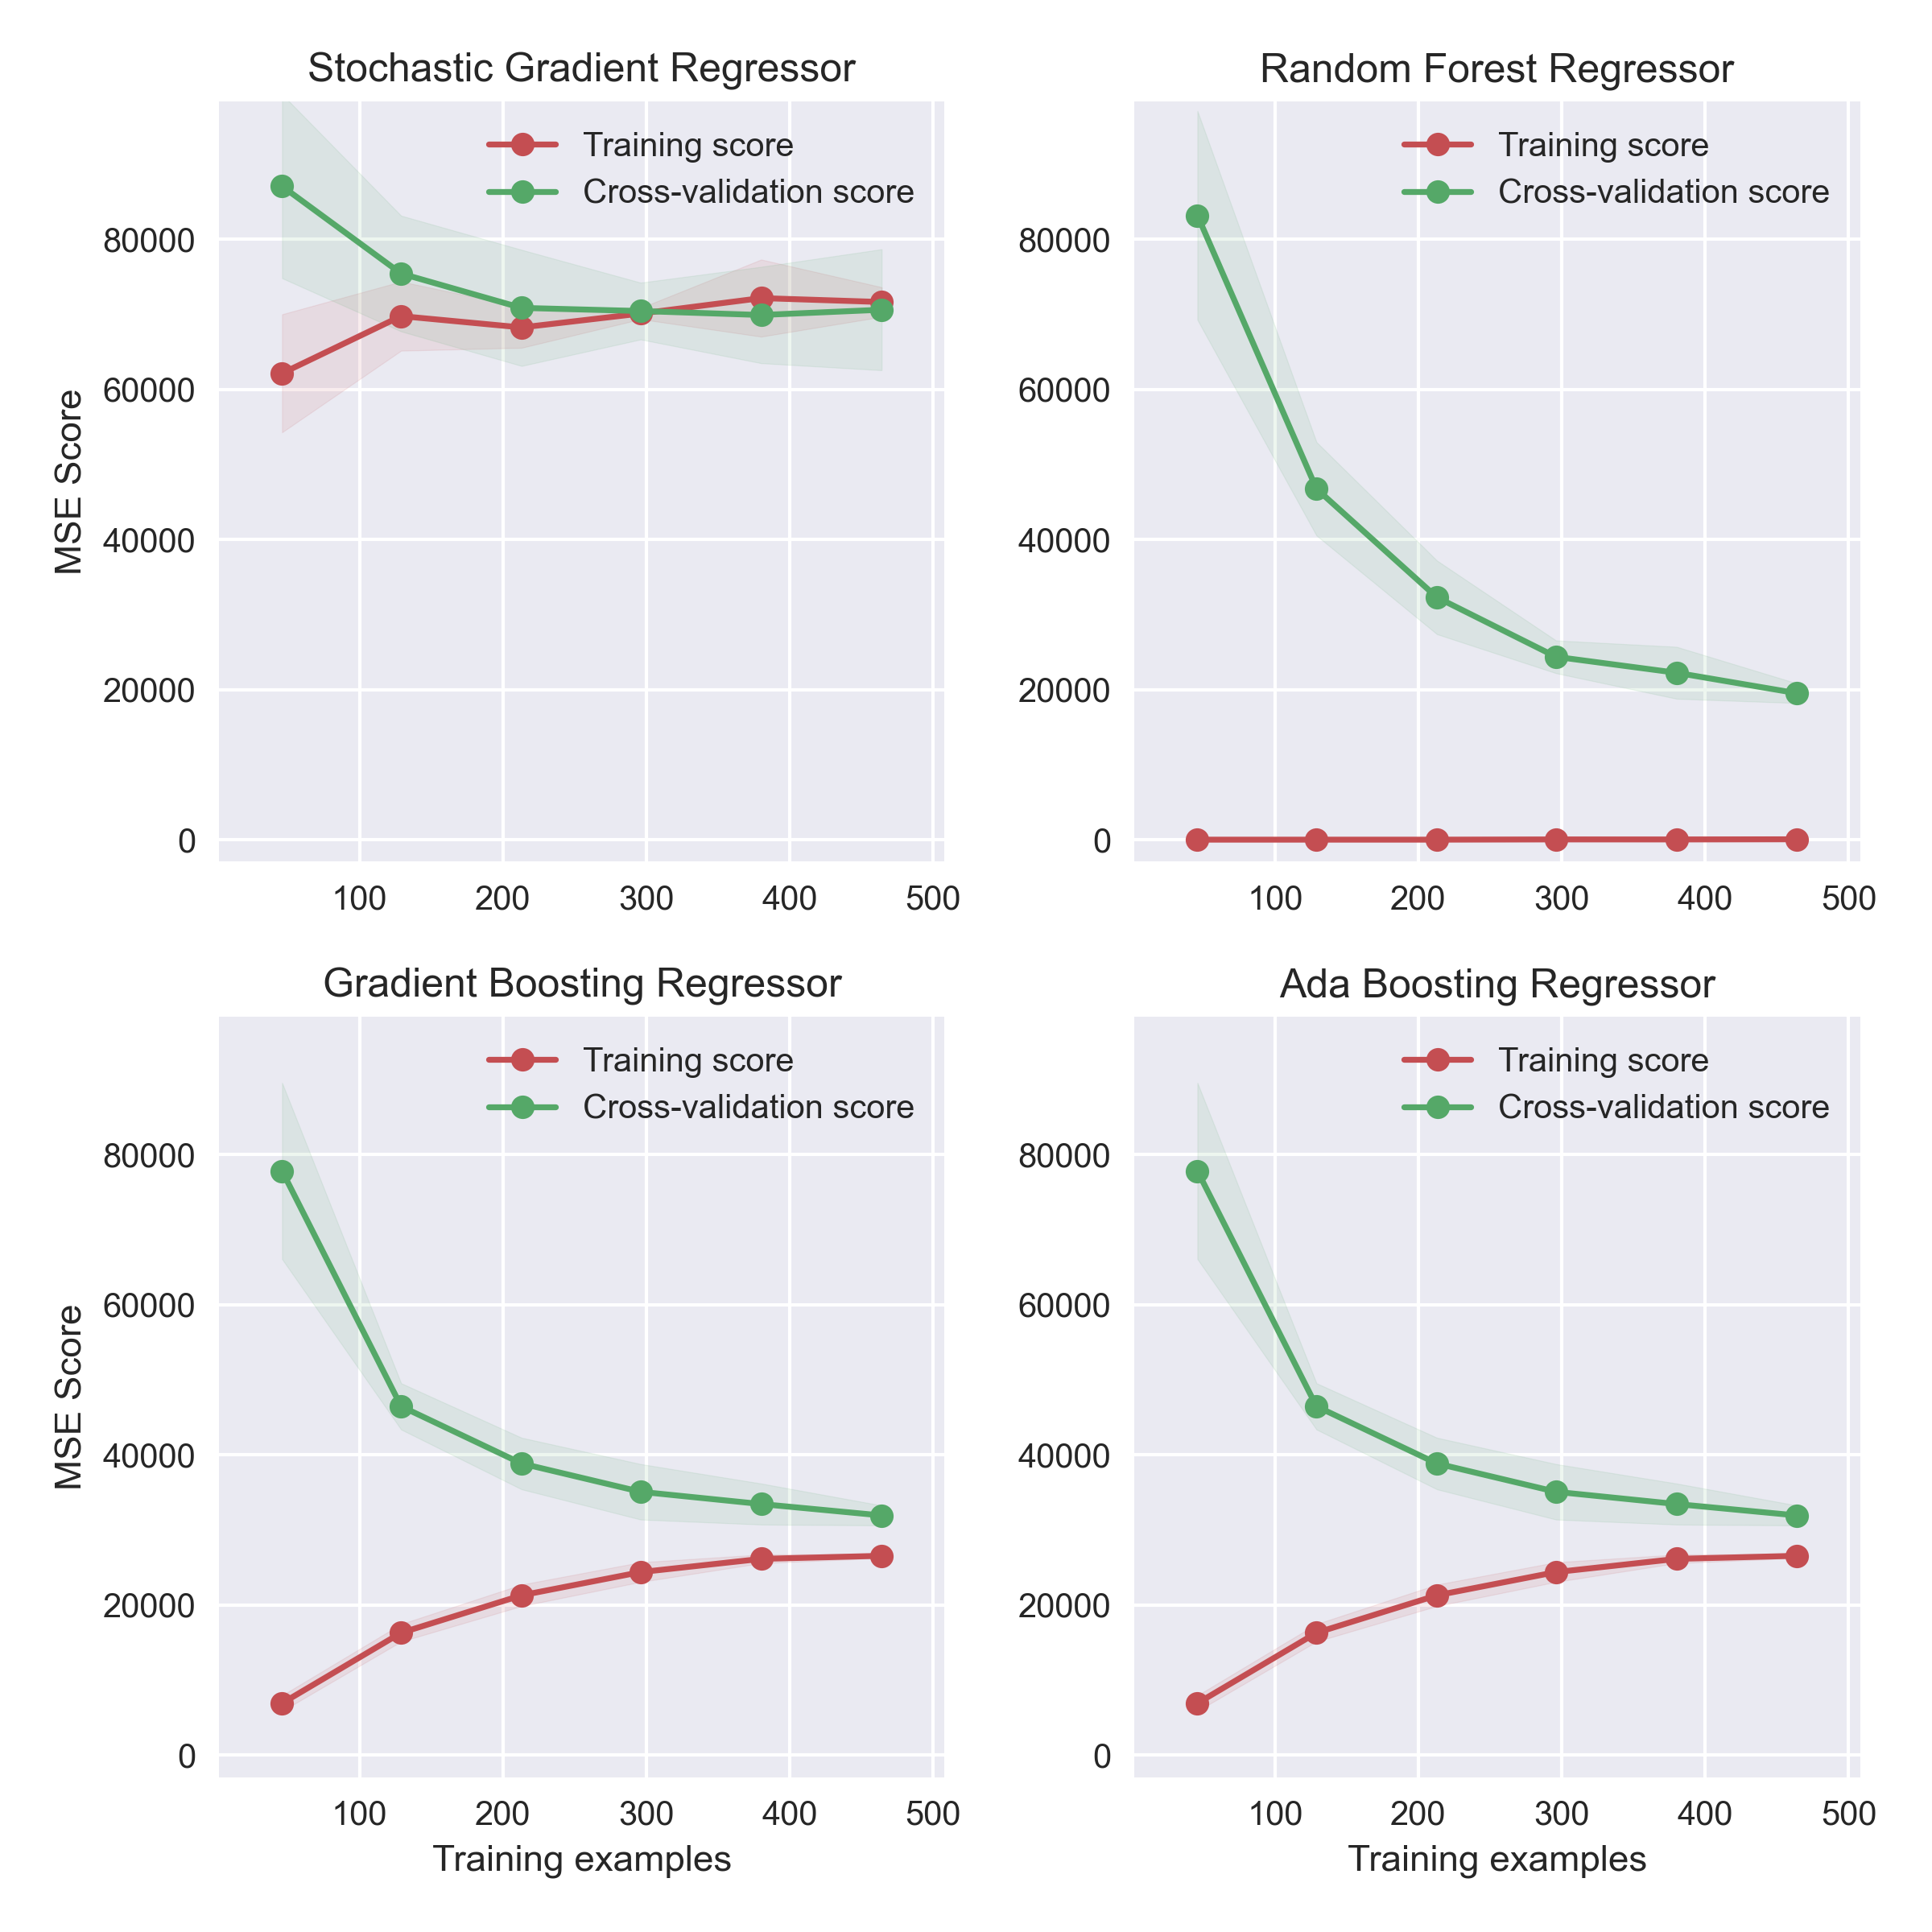

In [15]:
from IPython.display import Image
Image("./images/total_learning_curves.png",width=500, height=500)

**Model summary**

In [16]:
from model import model_load
import pandas as pd

models = model_load()

labels = {}
for key, item in models.items():
    labels[key.upper()] = type(item.best_estimator_["reg"]).__name__
    
bm = pd.DataFrame.from_dict(labels, orient="index", columns=["best model"])
bm


Loading models


,best model
EIRE,RandomForestRegressor
FRANCE,RandomForestRegressor
GERMANY,RandomForestRegressor
HONG_KONG,GradientBoostingRegressor
NETHERLANDS,RandomForestRegressor
NORWAY,RandomForestRegressor
PORTUGAL,RandomForestRegressor
SINGAPORE,AdaBoostRegressor
SPAIN,RandomForestRegressor
TOTAL,RandomForestRegressor


**Conclusion**

1. For Total revenues the best prediction is provided by Random Forrest having the lowest value of MSE (Mean Square Error) across four different model types used.

# Part 3 - Model production

The objectives of this part of the projekt are as follows:

1. Ready your model for deployment.
2. Query your API with new data and test your monitoring tools.
3. Compare your results to the gold standard.

## Tasks

1. Build a draft version of an API with train, predict, and logfile endpoints.
2. Using Docker, bundle your API, model, and unit tests.
3. Using test-driven development iterate on your API in a way that anticipates scale, load, and drift.
4. Create a post-production analysis script that investigates the relationship between model performance and the business metric.
5. Articulate your summarized findings in a final report.

## 1. Create API

Flask API performs the train, predict and logfile tasks


**Flask application script**

In [17]:
%%writefile application.py

import argparse
from flask import Flask
from flask import jsonify
from flask import request
from flask import render_template
import joblib
import socket
import json
import numpy as np
import pandas as pd
import os

## import model specific functions and variables
from model import *
from log import *

app = Flask(__name__)

@app.route("/")
def hello():
    html = "<h1>Hello {name}!</h1>" \
           "<b>Hostname:</b> {hostname}<br/>"
    return html.format(name=os.getenv("NAME", "world"), hostname=socket.gethostname())

@app.route('/predict', methods=['GET','POST'])
def predict():
    """
    basic predict function for the API
    """
    
    ## input checking
    if not request.json:
        print("ERROR: API (predict): did not receive request data")
        return jsonify([])
    
    if 'country' not in request.json:
        print("ERROR API (predict): received request, but no 'country' found within")
        return jsonify(False)
        
    if 'year' not in request.json:
        print("ERROR API (predict): received request, but no 'year' found within")
        return jsonify(False)
        
    if 'month' not in request.json:
        print("ERROR API (predict): received request, but no 'month' found within")
        return jsonify(False)
        
    if 'day' not in request.json:
        print("ERROR API (predict): received request, but no 'day' found within")
        return jsonify(False)
    
    if 'dev' not in request.json:
        print("ERROR API (predict): received request, but no 'dev' found within")
        return jsonify([])
    
    if 'verbose' not in request.json:
        print("WARNING API (predict): received request, but no 'verbose' found within")
        verbose = 'True'
    else:
        verbose = request.json['verbose']
        
    ## predict
    _result = result = model_predict(year=request.json['year'],
                                     month=request.json['month'],
                                     day=request.json['day'],
                                     country=request.json['country'],
                                     dev=request.json['dev']=="True",
                                     verbose=verbose=="True")
    
    result = {}
    ## convert numpy objects so ensure they are serializable
    for key,item in _result.items():
        if isinstance(item,np.ndarray):
            result[key] = item.tolist()
        else:
            result[key] = item

    return(jsonify(result))

@app.route('/train', methods=['GET','POST'])
def train():
    """
    basic train function for the API
    the 'dev' parameter provides ability to toggle between a DEV version and a PROD verion of training
    """

    if not request.json:
        print("ERROR: API (train): did not receive request data")
        return jsonify(False)

    if 'dev' not in request.json:
        print("ERROR API (train): received request, but no 'dev' found within")
        return jsonify(False)
    
    if 'verbose' not in request.json:
        print("WARNING API (predict): received request, but no 'verbose' found within")
        verbose = 'True'
    else:
        verbose = request.json['verbose']

    print("... training model")
    model = model_train(dev=request.json['dev']=="True", verbose=verbose=="True")
    print("... training complete")

    return(jsonify(True))

@app.route('/logging', methods=['GET','POST'])
def load_logs():
    """
    basic logging function for the API
    """

    if not request.json:
        print("ERROR: API (train): did not receive request data")
        return jsonify(False)

    if 'env' not in request.json:
        print("ERROR API (log): received request, but no 'env' found within")
        return jsonify(False)
        
    if 'type' not in request.json:
        print("ERROR API (log): received request, but no 'type' found within")
        return jsonify(False)
        
    if 'month' not in request.json:
        print("ERROR API (log): received request, but no 'month' found within")
        return jsonify(False)
        
    if 'year' not in request.json:
        print("ERROR API (log): received request, but no 'year' found within")
        return jsonify(False)
    
    print("... fetching logfile")
    logfile = log_load(env=request.json['env'],
                       tag=request.json['type'],
                       year=request.json['year'],
                       month=request.json['month'])
    
    result = {}
    result["logfile"]=logfile
    return(jsonify(result))

if __name__ == '__main__':

    ## parse arguments for debug mode
    ap = argparse.ArgumentParser()
    ap.add_argument("-d", "--debug", action="store_true", help="debug flask")
    args = vars(ap.parse_args())

    if args["debug"]:
        app.run(debug=True, port=8080)
    else:
        app.run(host='0.0.0.0', threaded=True ,port=8080)


Overwriting application.py


**Run Flask API application**

Start application inside project directory

```bash
$ python application.py
```

Once successfully started then goto http://localhost:8080/

In [20]:
## API to predict; make take a long time to complete

import requests
from ast import literal_eval

query = {"year":"2019","month":"1","day":"1","country":"total","dev":"True","verbose":"True"}
port = 8080
r = requests.post('http://localhost:{}/predict'.format(port),json=query)
response = literal_eval(r.text)
print(response)


{'y_pred': [188900.44309999933]}


In [21]:
## API to train; make take a long time to complete

query = {"dev":"True","verbose":"True"}
port = 8080
r = requests.post('http://localhost:{}/train'.format(port),json=query)


In [22]:
## API to log

query = {"env":"test","type":"train","year":"2020","month":"11"}
port = 8080
r = requests.post('http://localhost:{}/logging'.format(port),json=query)
response = literal_eval(r.text)
print(response)


{'logfile': 'test-train-2020-11.log'}


## 2. Bundle API, model and unit tests using Docker

**Initialize tests script**

In [23]:
## verify presence of tests directory

PROJECT_DIR = "."
TEST_DIR = os.path.join("unittests")

if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)

In [24]:
%%writefile ./unittests/__init__.py

import unittest
import getopt
import sys
import os

## parse inputs
try:
    optlist, args = getopt.getopt(sys.argv[1:],'v')
except getopt.GetoptError:
    print(getopt.GetoptError)
    print(sys.argv[0] + "-v")
    print("... the verbose flag (-v) may be used")
    sys.exit()

VERBOSE = False
RUNALL = False

sys.path.append(os.path.realpath(os.path.dirname(__file__)))

for o, a in optlist:
    if o == '-v':
        VERBOSE = True

## API tests
from APITests import *
APITestSet = unittest.TestLoader().loadTestsFromTestCase(APITest)

## model tests
from ModelTests import *
ModelTestSet = unittest.TestLoader().loadTestsFromTestCase(ModelTest)

## log tests
from LogTests import *
LogTestSet = unittest.TestLoader().loadTestsFromTestCase(LogTest)

MainSet = unittest.TestSuite([APITestSet,ModelTestSet,LogTestSet])


Overwriting ./unittests/__init__.py


**Create API unit tests script**

In [25]:
%%writefile ./unittests/APITests.py

#!/usr/bin/env python
"""
API test set

these tests use the requests package however similar requests can be made with curl

e.g.
data = '{"key":"value"}'
curl -X POST -H "Content-Type: application/json" -d "%s" http://localhost:8080/predict'%(data)
"""

import sys
import os
import unittest
import requests
import re
from ast import literal_eval
import numpy as np
import pandas as pd

port = 8080

try:
    requests.post('http://localhost:{}/predict'.format(port))
    server_available = True
except:
    server_available = False
    
## test class for the main window function
class APITest(unittest.TestCase):
    """
    test the essential functionality
    """
    
    @unittest.skipUnless(server_available,"local server is not running")
    def test_predict(self):
        """
        test the predict functionality
        """
        
        query = {"year":"2019","month":"1","day":"1","country":"total","dev":"True","verbose":"True"}
        r = requests.post('http://localhost:{}/predict'.format(port),json=query)
        response = literal_eval(r.text)
        self.assertTrue(isinstance(response["y_pred"][0], float))

    @unittest.skipUnless(server_available,"local server is not running")
    def test_train(self):
        """
        test the train functionality
        """
      
        query = {"dev":"True","verbose":"False"}
        r = requests.post('http://localhost:{}/train'.format(port),json=query)
        train_complete = re.sub("\W+","",r.text)
        self.assertEqual(train_complete,'true')
        
    @unittest.skipUnless(server_available,"local server is not running")
    def test_logging(self):
        """
        test the logging functionality
        """
        
        query = {"env":"test","type":"train","year":"2020","month":"11"}
        r = requests.post('http://localhost:{}/logging'.format(port),json=query)
        response = literal_eval(r.text)
        self.assertEqual(response.get("logfile"),'test-train-2020-11.log')

### Run the tests
if __name__ == '__main__':
    unittest.main()


Overwriting ./unittests/APITests.py


**Run API unit tests script**

In [26]:
%run ./unittests/APITests.py

...
----------------------------------------------------------------------
Ran 3 tests in 191.057s

OK


**Create model unit tests script**

In [27]:
%%writefile ./unittests/ModelTests.py

#!/usr/bin/env python

"""
model tests
"""

import unittest
from model import *

class ModelTest(unittest.TestCase):
    """
    test the essential functionality
    """
    
    def test_01_train(self):
        """
        test the train functionality
        """
    
        ## train the model
        model_train(verbose=False)
        
        prefix = "test" if DEV else "prod"
        models = [f for f in os.listdir(MODEL_DIR) if re.search(prefix,f)]
        self.assertEqual(len(models),11)
        
    def test_02_load(self):
        """
        test the train functionality
        """
        
        ## load the model
        models = model_load(verbose=False)
        
        for tag, model in models.items():
            self.assertTrue("predict" in dir(model))
            self.assertTrue("fit" in dir(model))
        
    def test_03_predict(self):
        """
        test the predict function input
        """
    
        ## query inputs
        query = "2019", "1", "1", "total"
        
        ## load model first
        result = model_predict(year=query[0], month=query[1], day=query[2], country=query[3], verbose=False)
        y_pred = result["y_pred"]
        self.assertTrue(y_pred.dtype==np.float64)
            
    def test_04_predict(self):
        """
        test the predict function accuracy
        """
    
        ## example predict
        example_queries = [("2019", "1", "1", "total"),
                           ("2019", "5", "1", "singapore"),
                           ("2018", "1", "5", "spain")]
        
        for query in example_queries:
            result = model_predict(year=query[0], month=query[1], day=query[2], country=query[3], verbose=False)
            y_pred = result["y_pred"]
            self.assertTrue(y_pred.dtype==np.float64)
            
## run the tests
if __name__ == "__main__":
    unittest.main()


Overwriting ./unittests/ModelTests.py


**Run model unit tests script**

In [28]:
%run ./unittests/ModelTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 174.884s

OK


**Create log unit tests script**

In [29]:
%%writefile ./unittests/LogTests.py

#!/usr/bin/env python
"""
log tests
"""

import unittest
from log import *

class LogTest(unittest.TestCase):
    """
    test log functionality
    """
        
    def test_01_train(self):
        """
        test training functionality
        """

        ## train logfile
        today = date.today()
        logfile = "{}-train-{}-{}.log".format("test",today.year,today.month)
        log_path = os.path.join(LOG_DIR, logfile)
        
        self.assertTrue(os.path.exists(log_path))

    def test_02_predict(self):
        """
        test predicting functionality
        """
        
        ## train logfile
        today = date.today()
        logfile = "{}-predict-{}-{}.log".format("test",today.year,today.month)
        log_path = os.path.join(LOG_DIR, logfile)
        
        self.assertTrue(os.path.exists(log_path))

    def test_03_load(self):
        """
        test loading functionality
        """

        ## load model first
        logfile = log_load(env="test",tag="train",year=2020,month=11, verbose=False)
        log_path = os.path.join(LOG_DIR, logfile)
              
        with open(log_path, "r") as log:
            text = log.read()
        self.assertTrue(len(text.split("\n"))>2)

### Run the tests
if __name__ == '__main__':
    unittest.main()


Overwriting ./unittests/LogTests.py


**Run log unit tests script**

In [30]:
%run ./unittests/LogTests.py

...
----------------------------------------------------------------------
Ran 3 tests in 0.009s

OK


**Create single script to run all unit tests**

In [31]:
%%writefile run-tests.py
#!/usr/bin/python 

import sys
import unittest

from unittests import *
unittest.main()


Overwriting run-tests.py


**Run all unit tests script**

```bash
$ python run-tests.py
```

## Docker container

**Create requirement.txt file**

In [32]:
%%writefile requirements.txt

cython
numpy
flask
pandas
scikit-learn
matplotlib
IPython
seaborn


Overwriting requirements.txt


**Create DockerFile**

In [33]:
%%writefile Dockerfile

# Use an official Python runtime as a parent image
FROM python:3.9

RUN apt-get update && apt-get install -y \
python3-dev \
build-essential    
        
# Set the working directory to /app
WORKDIR /app

# Copy the current directory contents into the container at /app
ADD . /app

# Install any needed packages specified in requirements.txt
RUN pip install --upgrade pip
RUN pip install --no-cache-dir -r requirements.txt

# Make port 80 available outside container
EXPOSE 80

# Define environment variable
ENV NAME World

# Run application.py when the container launches
CMD ["python", "application.py"]


Overwriting Dockerfile


**Build the Docker image and run it**

To build the image:

```bash
~$ docker build -t ai-workflow-capstone-application .
```

To verify the image:
```bash
~$ docker image ls
```

To run Docker container:
```bash
~$ docker run -p 4000:8080 ai-workflow-capstone-application
```

In case you may need to delete docker image you ned to provide image ID or image name:
```bash
~$ docker image rm ai-workflow-capstone-application
```

## 3. Test containerized application

To test app is running:
http://localhost:4000/

In [34]:
## Call predict API

query = {"year":"2019","month":"1","day":"5","country":"total","dev":"True","verbose":"True"}
port = 4000
r = requests.post('http://localhost:{}/predict'.format(port),json=query)
response = literal_eval(r.text)
print(response)


{'y_pred': [140139.3311999995]}


In [36]:
## Call log API

query = {"env":"test","type":"train","year":"2020","month":"11"}
port = 4000
r = requests.post('http://localhost:{}/logging'.format(port),json=query)
response = literal_eval(r.text)
print(response)


{'logfile': 'test-train-2020-11.log'}


## 4. Post production analysis

Will use a function to simulate new samples using the bootstrap, ie. sampling with replacement. WWhen running the simualtion function we will see how the data change.

**Create script for performance monitoring**

In [52]:
%%writefile monitor.py
#!/usr/bin/env python

import time
import numpy as np
import pandas as pd

from data_engineering import engineer_features
from model import _model_train, model_predict
from sklearn.metrics import mean_squared_error
from sklearn.covariance import EllipticEnvelope
from scipy.stats import wasserstein_distance
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## switch to production
DEV = False

def simulate_samples(n_samples, X, y, dates):
    """
    simulate new samples with bootstrap
    """
    
    indices = np.arange(y.size)
    new_indices = np.random.choice(indices, n_samples, replace=True)
    
    X_new = X[new_indices,:]
    y_new = y[new_indices]
    dates_new = dates[new_indices]
    return X_new, y_new, dates_new


def model_monitor(country="total", dev=DEV, training=True):
    """
    performance monitoring
    """
    print("Monitor Model")
    
    ## import data
    datasets = engineer_features(training=training, dev=dev)
    X, y, dates, labels = datasets[country]
    dates = pd.to_datetime(dates)
    print(X.shape)
    
    ## train the model
    if training:
        _model_train(X, y, labels, tag=country, dev=dev)
    
    ## monitor RMSE
    samples = [10, 20, 30, 40, 50, 60, 70, 80, 90]

    for n in samples:
        X_new, y_new, dates_new = simulate_samples(n, X, y, dates)
        queries = [(str(d.year), str(d.month), str(d.day), country) for d in dates_new]
        y_pred = [model_predict(year=query[0], month=query[1], day=query[2], country=query[3],verbose=False, dev=dev)["y_pred"][0].round(2) for query in queries]
        rmse = np.sqrt(mean_squared_error(y_new.tolist(),y_pred))
        print("sample size: {}, RSME: {}".format(n, rmse.round(2)))
        
    ## monitor performance
    ## scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    samples = [25, 50, 75, 90]

    ## testing for outliers, using the Elliptic Envelop, a variance based method
    clf_y = EllipticEnvelope(random_state=0,contamination=0.01)
    clf_X = EllipticEnvelope(random_state=0,contamination=0.01)

    clf_X.fit(X)
    clf_y.fit(y.reshape(y.size,1))

    ## distributional changes we will observe with Wasserstein metric
    ## we run both of these checks on the features and on the targets
    results = defaultdict(list)
    for n in samples:
        X_new, y_new, dates_new = simulate_samples(n,X,y, dates)
        results["sample_size"].append(n)
        results['wasserstein_X'].append(np.round(wasserstein_distance(X.flatten(),X_new.flatten()),2))
        results['wasserstein_y'].append(np.round(wasserstein_distance(y,y_new),2))
        test1 = clf_X.predict(X_new)
        test2 = clf_y.predict(y_new.reshape(y_new.size,1))
        results["outlier_percent_X"].append(np.round(1.0 - (test1[test1==1].size / test1.size),2))
        results["outlier_percent_y"].append(np.round(1.0 - (test2[test2==1].size / test2.size),2))
    
    return pd.DataFrame(results)
    
    
if __name__ == "__main__":
    
    run_start = time.time()
  
    ## monitor model
    result = model_monitor(dev=DEV)
    
    print(result)
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("Completed in:", "%d:%02d:%02d"%(h, m, s))
    

Overwriting monitor.py


**Execute performance monitoring script**

In [53]:
%run monitor.py

Monitor Model
Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Engineering Features and Target
(98, 9)
...training model: 4/4
...best model:Random Forest
...updating train log
sample size: 10, RSME: 6723.48
sample size: 20, RSME: 5704.12
sample size: 30, RSME: 3157.3
sample size: 40, RSME: 5044.04
sample size: 50, RSME: 4933.9
sample size: 60, RSME: 6107.32
sample size: 70, RSME: 7060.43
sample size: 80, RSME: 6631.1
sample size: 90, RSME: 6224.44
   sample_size  wasserstein_X  wasserstein_y  outlier_percent_X  \
0           25           0.09       11865.65               0.00   
1           50           0.08        6564.83               0.00   
2           75           0.12        8886.45               0.01   
3           90           0.19       11831.04               0.00   

   outlier_percent_y  
0               0.04  
1               0.00  
2               0.00  
3               0.01  
Completed in: 0:09:19


**Run performance monitoring script simulating data with different sizes** 

In [54]:
from monitor import model_monitor

results_df = model_monitor(dev=False)

Monitor Model
Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Engineering Features and Target
(98, 9)
...training model: 4/4
...best model:Random Forest
...updating train log
sample size: 10, RSME: 6915.64
sample size: 20, RSME: 4499.7
sample size: 30, RSME: 3817.66
sample size: 50, RSME: 4280.24
sample size: 60, RSME: 7168.08


**Simulation summary**

In [55]:
(results_df
 .style
 .hide_index()
 .bar(color='lightblue', vmin=0, subset=['wasserstein_X'], align='zero')
 .bar(color='lightblue', vmin=0, subset=['wasserstein_y'], align='zero')
 .bar(color='red', vmin=0, vmax=0.1,subset=['outlier_percent_X'], align='zero')
 .bar(color='red', vmin=0, vmax=0.1,subset=['outlier_percent_y'], align='zero')
 .set_caption('Performance Monitoring'))

sample_size,wasserstein_X,wasserstein_y,outlier_percent_X,outlier_percent_y
25,0.290000,21853.460000,0.000000,0.040000
50,0.110000,10427.930000,0.020000,0.000000
75,0.070000,7597.090000,0.010000,0.000000
90,0.190000,12516.160000,0.010000,0.020000


## 5. Summary of perfomance monitoring findings

1. RMSE score varies with regard to the size of the samples. 
2. When monitoring based on RMSE score we would need big samples of data to came with conclusions.